# Two Resistance Mechanism (TRM) method

Notes on how this is working!

Variables needed:  
* Looks good: lambda0, ro, ra, rs, Rnet, delta, qsat_Ta, qa, rho, gamma, 
* No nan, but looks weird: 
    * f
    * delta_rs
    
* OVERESTIMATING CHANGES FROM rs and ra, especially in high lats. Work on getting the albedo vars to look reasonable first.

* SENSITIVITY TO rs in ICE REGIONS DOES NOT MAKE SENSE... SHOULD NOT BE NEGATIVE EVER

Filters currently used:
* SH > 5 (for calculating ra)
* LH > 5 (for calculating rs)
* ra > 0
* rs > 0
* calculated emissivity <=1
* Tdiff = Ts-Ta > 0 (for calculating ra)
* qdiff = qsat_Ts - qa > 0 (for calculating rs)
* delta_rs <=1000

# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/offline_mechanism/')

In [3]:
from load_ensembles import *

In [4]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [5]:
from utils import *

In [6]:
from load_gridcell_areas import *

In [7]:
#import sympy

# Load data from reference simulation

Variables needed:
##### *Atmospheric Inputs*
    * TBOT (Atmospheric temperature: available daily and monthly)
    * QBOT (Atmospheric specific humidity: available daily and monthly)
    * PBOT
    * FSDS (Incoming SW radiation: available daily and monthly)
    * FLDS (Incoming LW radiation: available daily and monthly)
    
##### *Land surface fluxes/state* 
    * EFLX_LH_TOT (Latent heat: available daily and monthly)
    * FSH_TO_COUPLER (Sensible heat: available daily and monthly)
    * Ts
    * FSA (can be calculated from FSR: available daily and monthly)
    * FIRE (Emitted LW radiation: available daily and monthly)
    * FIRA - maybe don't need??

In [8]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/OFFL0001_PI_v02/lnd/hist/'+
                     'OFFL0001_PI_v02.clm2.h0.0129-02-01-00000.nc')

### Load reference data

In [9]:
spin_up_yr=40

In [10]:
### Load reference data
key_ref='OFFL0000_PI_v02'

ds_Ta_ref=get_dataset(ensemble_dir='offline_simulations',var='TBOT', key=key_ref)['TBOT'][spin_up_yr*12:,:,:]
ds_qa_ref=get_dataset(ensemble_dir='offline_simulations',var='QBOT', key=key_ref)['QBOT'][spin_up_yr*12:,:,:]
ds_P_ref=get_dataset(ensemble_dir='offline_simulations',var='PBOT', key=key_ref)['PBOT'][spin_up_yr*12:,:,:]
ds_FSDS_ref=get_dataset(ensemble_dir='offline_simulations',var='FSDS', key=key_ref)['FSDS'][spin_up_yr*12:,:,:]
ds_FLDS_ref=get_dataset(ensemble_dir='offline_simulations',var='FLDS', key=key_ref)['FLDS'][spin_up_yr*12:,:,:]

met_ref=met_driver_data(ds_FSDS_ref, ds_FLDS_ref, ds_Ta_ref, ds_qa_ref, ds_P_ref)

### Make gridded time series

In [11]:
### Reference simulation
LH_ref=get_dataset(ensemble_dir='offline_simulations',var='EFLX_LH_TOT', key=key_ref)['EFLX_LH_TOT'][spin_up_yr*12:,:,:]
SH_ref=get_dataset(ensemble_dir='offline_simulations',var='FSH', key=key_ref)['FSH'][spin_up_yr*12:,:,:]
Ts_ref=get_dataset(ensemble_dir='offline_simulations',var='TSKIN', key=key_ref)['TSKIN'][spin_up_yr*12:,:,:]

FSA_ref=get_dataset(ensemble_dir='offline_simulations',var='FSA', key=key_ref)['FSA'][spin_up_yr*12:,:,:]
FIRA_ref=get_dataset(ensemble_dir='offline_simulations',var='FIRA', key=key_ref)['FIRA'][spin_up_yr*12:,:,:]
FIRE_ref=get_dataset(ensemble_dir='offline_simulations',var='FIRE', key=key_ref)['FIRE'][spin_up_yr*12:,:,:]

# Calculate sensitivities from reference simulation

#### *Functions for calculating variables*

In [12]:
def calculate_albedo(FSDS, FSA):
    # Albedo
    return (1-(FSA/FSDS))

In [13]:
def calculate_emissivity(FIRE, Ts, sigma=CONSTANT_sigma):
    emissivity= FIRE/(sigma*(Ts**4))
    emissivity=emissivity.where(emissivity<=1,1).where(~np.isnan(Ts))
    return emissivity

In [14]:
def calculate_G(Rnet, SH, LH):
    #Rnet=SH+LH+G
    #G=Rnet-SH-LH
    return (Rnet - SH - LH)

### *Do reference calculations*

In [15]:
albedo_ref=calculate_albedo(ds_FSDS_ref, FSA_ref)
emissivity_ref=calculate_emissivity(FIRE_ref, Ts_ref, sigma=CONSTANT_sigma)
Rnet_ref=calculate_Rn_star(met_ref.SWin, albedo_ref, met_ref.LWin, emissivity_ref, met_ref.Ta)

In [16]:
Rnet_exact=calculate_Rnet(FSA_ref, FIRA_ref)

In [17]:
G_ref=calculate_G(Rnet_exact, SH_ref, LH_ref)
G_ref_seasonal=G_ref.groupby('time.month').mean(dim='time').load()

In [18]:
met_ref.calculate_other_params()

In [19]:
def calculate_rah_simple(met, Ts, SH):
    ra_ref=met.rho*CONSTANT_Cp*(Ts-met.Ta)/SH
    return ra_ref.load()

def calculate_raw_simple(met, Ts, LH, sublimation_threshold=273.15):
    SHR_CONST_LATICE  = 3.337e5#latent heat of fusion      ~ J/kg
    SHR_CONST_LATVAP  = 2.501e6#latent heat of evaporation ~ J/kg
    SHR_CONST_LATSUB  = SHR_CONST_LATICE + SHR_CONST_LATVAP # latent heat of sublimation ~ J/kg

    qsat_Ts=calculate_qsat(Ts, met.P)
    qdiff=qsat_Ts-met.qa
    raw=met.rho*CONSTANT_Lv*qdiff/LH
    
    raw_sub=met.rho*SHR_CONST_LATSUB*(qsat_Ts-met.qa)/LH
    raw_combo=raw.where(Ts>sublimation_threshold,raw_sub)
    
    return raw_combo

In [20]:
rah_ref_unfiltered=calculate_rah_simple(met_ref, Ts_ref, SH_ref)
raw_ref_unfiltered=calculate_raw_simple(met_ref, Ts_ref, LH_ref)
rs_ref_unfiltered=raw_ref_unfiltered-rah_ref_unfiltered
#ra_ref_unfiltered=ra_ref_unfiltered.where(ra_ref_unfiltered>0)
#rs_ref_unfiltered=raw_ref_unfiltered-ra_ref_unfiltered
#rs_ref_unfiltered=rs_ref_unfiltered.where(rs_ref_unfiltered>0)

In [21]:
rah_ref=rah_ref_unfiltered.where((rah_ref_unfiltered>0)&(rah_ref_unfiltered<=1000))
raw_ref=raw_ref_unfiltered.where(raw_ref_unfiltered>0)
rs_ref=raw_ref-rah_ref
rs_ref=rs_ref.where(rs_ref>0)

In [22]:
f_ref_unfiltered=calculate_f(met_ref.ro, 
                             rah_ref_unfiltered, 
                             rs_ref_unfiltered, 
                             met_ref.delta, met_ref.gamma)

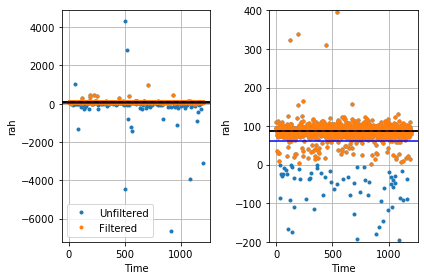

In [23]:
i=0
j=1
plt.subplot(1,2,1)
plt.plot(rah_ref_unfiltered[:,i,j],'.', label='Unfiltered')
plt.plot(rah_ref[:,i,j],'.', label='Filtered')
plt.legend()
plt.xlabel('Time')
plt.ylabel('rah')
plt.axhline(y=np.nanmean(rah_ref_unfiltered[:,i,j]),linestyle='-',color='blue')
plt.axhline(y=np.nanmean(rah_ref[:,i,j]),linestyle='-',color='k')
plt.axhline(y=np.nanmedian(rah_ref_unfiltered[:,i,j]),linestyle=':',color='firebrick')
plt.axhline(y=np.nanmedian(rah_ref[:,i,j]),linestyle='--',color='k')
plt.grid()
plt.subplot(1,2,2)
plt.plot(rah_ref_unfiltered[:,i,j],'.')
plt.plot(rah_ref[:,i,j],'.')
plt.ylim([-200,400])
plt.axhline(y=np.nanmean(rah_ref_unfiltered[:,i,j]),linestyle='-',color='blue')
plt.axhline(y=np.nanmean(rah_ref[:,i,j]),linestyle='-',color='k')
plt.axhline(y=np.nanmedian(rah_ref_unfiltered[:,i,j]),linestyle=':',color='firebrick')
plt.axhline(y=np.nanmedian(rah_ref[:,i,j]),linestyle='--',color='k')
plt.xlabel('Time')
plt.ylabel('rah')
plt.grid()
plt.tight_layout()

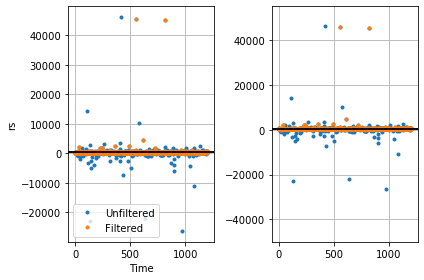

In [24]:
i=70
j=100
plt.subplot(1,2,1)
plt.plot(rs_ref_unfiltered[:,i,j],'.', label='Unfiltered')
plt.plot(rs_ref[:,i,j],'.', label='Filtered')
plt.axhline(y=np.nanmean(rs_ref_unfiltered[:,i,j]),linestyle='-',color='blue')
plt.axhline(y=np.nanmean(rs_ref[:,i,j]),linestyle='-',color='k')
plt.axhline(y=np.nanmedian(rs_ref_unfiltered[:,i,j]),linestyle=':',color='firebrick')
plt.axhline(y=np.nanmedian(rs_ref[:,i,j]),linestyle='--',color='k')
plt.legend()
plt.xlabel('Time')
plt.ylabel('rs')
plt.grid()
plt.subplot(1,2,2)
plt.plot(rs_ref_unfiltered[:,i,j],'.')
plt.plot(rs_ref[:,i,j],'.')
plt.ylim([-50000,55000])
plt.axhline(y=np.nanmean(rs_ref_unfiltered[:,i,j]),linestyle='-',color='blue')
plt.axhline(y=np.nanmean(rs_ref[:,i,j]),linestyle='-',color='k')
plt.axhline(y=np.nanmedian(rs_ref_unfiltered[:,i,j]),linestyle=':',color='firebrick')
plt.axhline(y=np.nanmedian(rs_ref[:,i,j]),linestyle='--',color='k')
plt.grid()
plt.tight_layout()

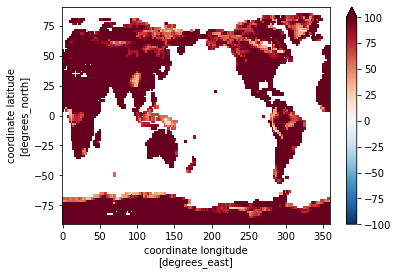

In [25]:
rs_ref.load().median(dim='time').plot(vmax=100, cmap=plt.cm.RdBu_r, vmin=-100)

In [26]:
ra_ref=calculate_ra(Ts_ref, met_ref.Ta, SH_ref, met_ref.P, met_ref.qa)
ra_ref=ra_ref.where(ra_ref>0)
rs_ref=calculate_rs(Ts_ref, met_ref.Ta, met_ref.qa, LH_ref, ra_ref, met_ref.P)
rs_ref=rs_ref.where(rs_ref>0)
f_ref=calculate_f(met_ref.ro, 
                             ra_ref, 
                             rs_ref, 
                             met_ref.delta, met_ref.gamma)
#rs_ref_avg_filled=rs_ref_avg.where(~np.isnan(rs_ref_avg),50).where(~np.isnan(landfrac))

#G_ref = calculate_G(Rnet_ref, SH_ref, LH_ref)

### Check calculated quantities

In [27]:
f_ref_seasonal=(f_ref).groupby('time.month').mean(dim='time').load()
rs_ref_seasonal=(rs_ref).groupby('time.month').mean(dim='time').load()
ra_ref_seasonal=(ra_ref).groupby('time.month').mean(dim='time').load()

In [28]:
f_ref_avg=(f_ref).mean(dim='time').load()
rs_ref_avg=(rs_ref).mean(dim='time').load()
ra_ref_avg=(ra_ref).mean(dim='time').load()

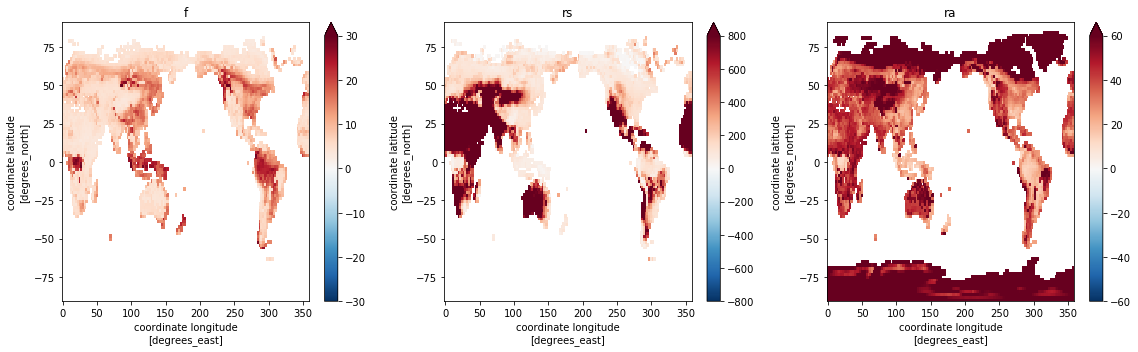

In [29]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
f_ref_avg.plot(vmin=-30, vmax=30, cmap=plt.cm.RdBu_r)
plt.title('f')
plt.subplot(1,3,2)
rs_ref_avg.plot(vmin=-800, vmax=800, cmap=plt.cm.RdBu_r)
plt.title('rs')
plt.subplot(1,3,3)
ra_ref_avg.plot(vmin=-60, vmax=60, cmap=plt.cm.RdBu_r)
plt.title('ra')
plt.tight_layout()

In [30]:
# DOESNT WEED OUT TOO MUCH DATA: SH filter, Tdiff filter, 
# DOES WEED OUT QUITE A BIT OF HIGH LATITUDE DATA: LH filter, qdiff filter


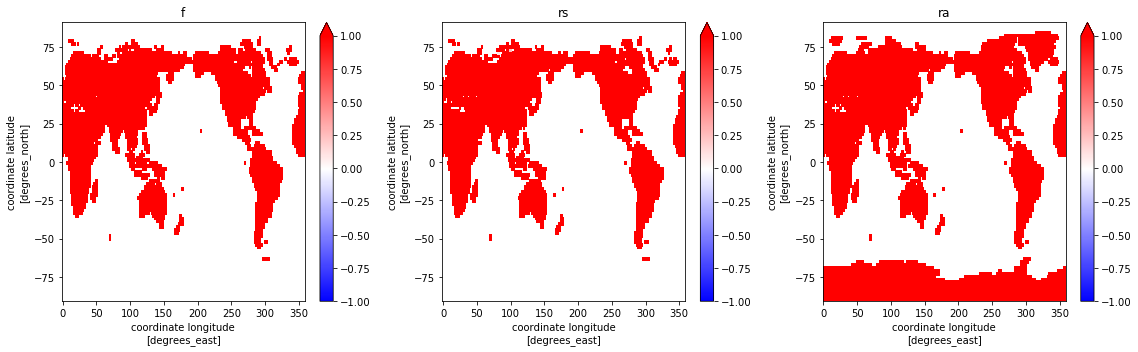

In [31]:
### Check sign
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
f_ref_avg.plot(vmin=-1, vmax=1, cmap=plt.cm.bwr)
plt.title('f')
plt.subplot(1,3,2)
rs_ref_avg.plot(vmin=-1, vmax=1, cmap=plt.cm.bwr)
plt.title('rs')
plt.subplot(1,3,3)
ra_ref_avg.plot(vmin=-1, vmax=1, cmap=plt.cm.bwr)
plt.title('ra')
plt.tight_layout()

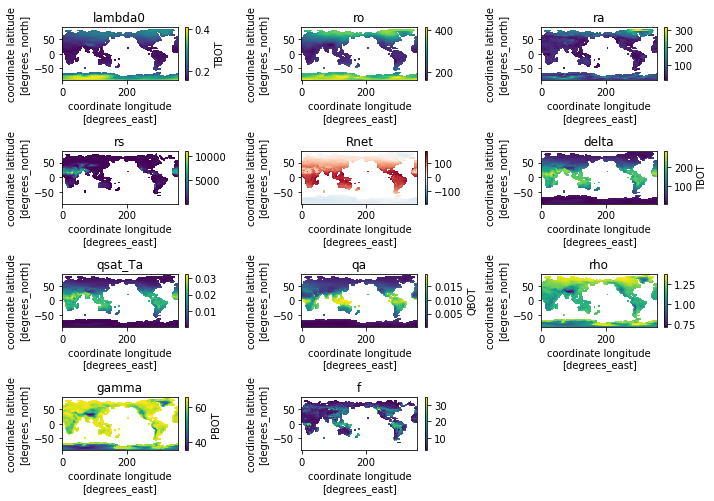

In [32]:
plt.figure(figsize=(10,7))
datasets=[met_ref.lambda0.mean(dim='time').load(), 
          met_ref.ro.mean(dim='time').load(), 
          ra_ref_avg, 
          rs_ref_avg, 
          Rnet_ref.mean(dim='time').load(), 
          met_ref.delta.mean(dim='time').load(), 
          met_ref.qsat_Ta.mean(dim='time').load(), 
          met_ref.qa.mean(dim='time').load(), 
          met_ref.rho.mean(dim='time').load(), 
          met_ref.gamma.mean(dim='time').load(),
          f_ref_avg]
labels=['lambda0','ro','ra','rs','Rnet','delta','qsat_Ta','qa','rho','gamma',
        'f']
for i, var in enumerate(datasets):
    plt.subplot(4,3,i+1)
    var.plot()
    plt.title(labels[i])
plt.tight_layout()

### Look at errors in estimated temperature

In [33]:
def calculate_Ts(met, Rn, 
                 ra, rs, 
                 G=0, 
                 Lv=CONSTANT_Lv):
    met.calculate_other_params()
    lambda0=met.lambda0
    rho=met.rho
    qdiff=met.qsat_Ta-met.qa
    Ta=met.Ta

    f=calculate_f(met.ro, ra, rs, met.delta, met.gamma)
    
    term1=(Rnet_ref-((rho*Lv/(ra+rs))*qdiff))
    Tdiff=(lambda0*term1/(1+f)).load()
    Ts=Tdiff+Ta
    return Ts

In [34]:
def calculate_Ts_seasonal(met, Rn, 
                 ra, rs,
                 G=0, 
                 Lv=CONSTANT_Lv):
    met.calculate_other_params()
    
    lambda0=met.lambda0.groupby('time.month').mean(dim='time')
    rho=met.rho.groupby('time.month').mean(dim='time')
    qdiff=(met.qsat_Ta-met.qa).groupby('time.month').mean(dim='time')
    Ta=met.Ta.groupby('time.month').mean(dim='time')
    gamma=met.gamma.groupby('time.month').mean(dim='time')
    delta=met.delta.groupby('time.month').mean(dim='time')
    ro=met.ro.groupby('time.month').mean(dim='time')
    
    f=calculate_f(ro, ra, rs, delta, gamma)
    #f=f.groupby('time.month').mean(dim='time')

    term1=(Rn-((rho*Lv/(ra+rs))*qdiff))
    Tdiff=(lambda0*term1/(1+f)).load()
    Ts=Tdiff+Ta
    return Ts

In [35]:
Ts_est_seasonal=calculate_Ts_seasonal(met_ref, 
                                      Rnet_ref.groupby('time.month').mean(dim='time'),
                                      ra_ref.groupby('time.month').mean(dim='time'), 
                                     rs_ref.groupby('time.month').mean(dim='time'), 
                                    G=G_ref.groupby('time.month').mean(dim='time'))

Ts_ref_seasonal=Ts_ref.groupby('time.month').mean(dim='time')
Ts_error_seasonal=Ts_est_seasonal-Ts_ref_seasonal

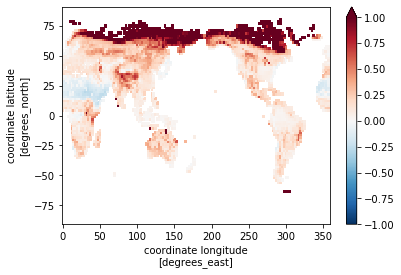

In [36]:
Ts_error_seasonal.mean(dim='month').plot(vmax=1)

In [37]:
Ts_est_seasonal=calculate_Ts_seasonal(met_ref, 
                                      Rnet_ref.groupby('time.month').mean(dim='time'),
                    ra_ref_unfiltered.groupby('time.month').mean(dim='time'), 
                             rs_ref_unfiltered.groupby('time.month').mean(dim='time'), 
                    G=G_ref.groupby('time.month').mean(dim='time'))

Ts_ref_seasonal=Ts_ref.groupby('time.month').mean(dim='time')
Ts_error_seasonal=Ts_est_seasonal-Ts_ref_seasonal

NameError: name 'ra_ref_unfiltered' is not defined

In [ ]:
Ts_error_seasonal.mean(dim='month').plot(vmax=1)

In [ ]:
deltaTs=Ts_est_seasonal2.mean(dim='month')-Ts_est_seasonal.mean(dim='month')

In [ ]:
deltaTs.plot(vmax=0.3)

In [ ]:
deltaTs.plot()

In [ ]:
Ts_est_seasonal2=calculate_Ts_seasonal(met_ref, 
                                      Rnet_ref.groupby('time.month').mean(dim='time'),
                    ra_ref_unfiltered.groupby('time.month').mean(dim='time')+10, 
                             rs_ref_unfiltered.groupby('time.month').mean(dim='time'), 
                    G=G_ref.groupby('time.month').mean(dim='time'))

In [ ]:
Ts_error_seasonal[11,:,:].plot(vmax=1)

### Calculate deltas

In [120]:
# Offline deltas
[dTs_dRn, dTs_dra, dTs_drs]=calculate_partial_derivs(met_ref, 
                                                     ra_ref, 
                                                     rs_ref+100, 
                                                     albedo_ref, 
                                                     emissivity_ref,
                                                     G_ref)

dTs_dRn_seasonal=dTs_dRn.groupby('time.month').mean(dim='time')
dTs_dra_seasonal=dTs_dra.groupby('time.month').mean(dim='time')
dTs_drs_seasonal=dTs_drs.groupby('time.month').mean(dim='time')

In [32]:
# Coupled deltas
dTs_dTa=1
dTs_dqdiff = -met_ref.lambda0*met_ref.rho*CONSTANT_Lv/((1+f_ref)*(ra_ref+rs_ref))
dTs_dqsTa=dTs_dqdiff
dTs_dqa=-dTs_dqdiff

In [33]:
met_ref_seasonal=met_driver_data(ds_FSDS_ref.groupby('time.month').mean(dim='time'), 
                                 ds_FLDS_ref.groupby('time.month').mean(dim='time'), 
                                 ds_Ta_ref.groupby('time.month').mean(dim='time'), 
                                 ds_qa_ref.groupby('time.month').mean(dim='time'), 
                                 ds_P_ref.groupby('time.month').mean(dim='time'))

met_ref_seasonal.calculate_other_params()

[dTs_dRn_seasonal, 
 dTs_dra_seasonal, 
 dTs_drs_seasonal]=calculate_partial_derivs(met_ref_seasonal, 
                                                     ra_ref_seasonal, 
                                                     rs_ref_seasonal, 
                                                     albedo_ref.groupby('time.month').mean(dim='time'), 
                                                     emissivity_ref.groupby('time.month').mean(dim='time'),
                                                     G_ref_seasonal)#
                                                   # 0)#G_ref)

NameError: name 'ra_ref_seasonal' is not defined

In [121]:
dTs_dRn_avg=dTs_dRn_seasonal.mean(dim='month').load()
dTs_dra_avg=dTs_dra_seasonal.mean(dim='month').load()
dTs_drs_avg=dTs_drs_seasonal.mean(dim='month').load()

In [ ]:
#dTs_dRn_seasonal=dTs_dRn.groupby('time.month').mean(dim='time').load()
#dTs_dra_seasonal=dTs_dra.groupby('time.month').mean(dim='time').load()
#dTs_drs_seasonal=dTs_drs.groupby('time.month').mean(dim='time').load()

In [122]:
datasets=[dTs_drs_avg,
          dTs_dRn_avg, 
          dTs_dra_avg, ]
labels=['dTs_drs', 'dTs_dRn','dTs_dra']

#### Calculate second-order sensitivities

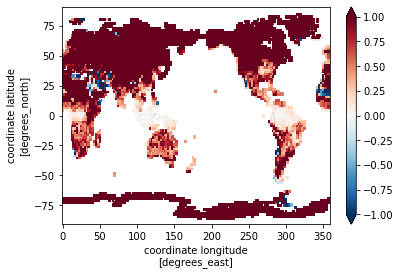

In [31]:
G=G_ref
Ts_est=(met_ref.lambda0*(Rnet_ref-G-
                         met_ref.rho*CONSTANT_Lv*(met_ref.qsat_Ta-met_ref.qa)/(ra_ref+rs_ref))/f_ref+
                         met_ref.Ta)

Ts_delta=(Ts_est.mean(dim='time')-Ts_ref.mean(dim='time')).plot(vmax=1)

In [32]:
lambda0=met_ref.lambda0.mean(dim='time').load()
f=f_ref.mean(dim='time').load()
a=lambda0*(Rnet_ref-0)#G
b=lambda0*met_ref.rho*CONSTANT_Lv*(met_ref.qsat_Ta-
                                                    met_ref.qa)

In [33]:
ro=met_ref.ro.mean(dim='time')
delta=met_ref.delta.mean(dim='time')
gamma=met_ref.gamma.mean(dim='time')
ra_avg=ra_ref.mean(dim='time').load()
rs_avg=rs_ref.mean(dim='time').load()

In [34]:
def calculate_d2f_drs2(ra, rs,
                     ro=ro,
                     delta=delta,
                     gamma=gamma):
    d2f_drs=2*delta*ro/(gamma*((ra+rs)**3))
    return d2f_drs

def calculate_d2f_dra2(ra, rs,
                      ro=ro,
                     delta=delta,
                     gamma=gamma):
    d2f_dra=2*ro*((ra*ra*ra*(delta+gamma))+
              (3*gamma*ra*ra*rs)+
              (3*gamma*ra*rs*rs)+
              (gamma*(rs*rs*rs)))/(gamma*(ra**3)*((ra+rs)**3))
    return d2f_dra

def calculate_d2f_dra_drs(ra,rs):
    d2f_dra_drs=2*delta*ro/(gamma*((ra+rs)**3))
    return d2f_dra_drs

def calculate_d2Ts_dra2(ra, rs, df_dra, d2f_dra2):
    term1=(1+f)*(a-(b/(ra+rs)))*d2f_dra2
    term2=2*(1+f)*(b/((ra+rs)*(ra+rs))+1)*df_dra
    term3=2*(a-(b/(ra+rs)))*df_dra*df_dra
    term4=2*b*(1+f)*(1+f)/((ra+rs)**3)
    d2Ts_dra2=-(term1+term2-term3+term4)/((1+f)**3)
    return d2Ts_dra2

def calculate_d2Ts_drs2(ra, rs, df_drs, d2f_drs2):
    term1=(1+f)*(a-(b/(ra+rs)))*d2f_drs2
    term2=2*b*(1+f)*df_drs/((ra+rs)*(ra+rs))
    term3=2*(a-(b/(ra+rs)))*df_drs*df_drs
    term4=2*b*(1+f)*(1+f)/((ra+rs)**3)
    d2Ts_drs2=-(term1+term2-term3+term4)/((1+f)**3)
    return d2Ts_drs2

def calculate_d2Ts_dra_drs(ra,rs,d2f_dra_drs,df_drs,df_dra):
    d2Ts_dra_drs=-((
    2*(ra+rs)*(ra+rs)*df_drs*df_dra*(b-a*(ra+rs))+
    (ra+rs)*(ra+rs)*(1+f)*(d2f_dra_drs)*(a*(ra+rs)-b)+
    (b*(ra+rs)*(1+f)*df_drs)+
    (b*(ra+rs)*(1+f)*df_dra)+
    (2*b*(1+f)*(1+f)))/
    (((ra+rs)**3)*((1+f)**3)))
    return d2Ts_dra_drs

In [35]:
def calculate_second_order_terms(delta_Rnet,
                                delta_ra,
                                delta_rs,
                                 ra,
                                 rs):
    
    d2f_drs2=calculate_d2f_drs2(ra_avg, rs_avg)
    d2f_dra2=calculate_d2f_dra2(ra_avg, rs_avg)
    d2f_dra_drs=calculate_d2f_dra_drs(ra_avg,rs_avg)
    df_dra=calculate_df_dra(ro, ra_avg, rs_avg, delta, gamma)
    df_drs=calculate_df_drs(ro, ra_avg, rs_avg, delta, gamma)
    
    # Second order terms
    d2Ts_dRn2=0
    d2Ts_dra2=calculate_d2Ts_dra2(ra_avg, rs_avg, df_dra, d2f_dra2)
    d2Ts_drs2=calculate_d2Ts_drs2(ra_avg, rs_avg, df_drs, d2f_drs2)

    # Mixed terms
    d2Ts_dRn_dra=-lambda0*df_dra/((1+f)*(1+f))
    d2Ts_dRn_drs=-lambda0*df_drs/((1+f)*(1+f))
    d2Ts_dra_drs=calculate_d2Ts_dra_drs(ra_avg,rs_avg,d2f_dra_drs,df_drs,df_dra)

    d2Ts_dRn2=0
    second_order_terms=0.5*((d2Ts_dRn2*(delta_Rnet*delta_Rnet))+
                        (d2Ts_dra2*(delta_ra*delta_ra))+ #medium (large in splotchy areas)
                        (d2Ts_drs2*(delta_rs*delta_rs))+ #big (positive)
                        (2*(d2Ts_dRn_dra)*delta_Rnet*delta_ra)+ #small
                        (2*d2Ts_dRn_drs*delta_Rnet*delta_rs)+ #small
                        (2*d2Ts_dra_drs*delta_ra*delta_rs) #small
                           )
    return second_order_terms

### Look at Ts sensitivity to various factors

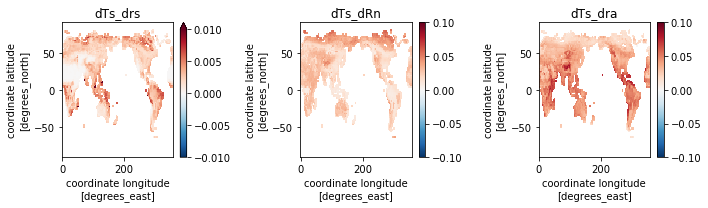

In [123]:
plt.figure(figsize=(10,3))
for i, var in enumerate(datasets):
    plt.subplot(1,3,i+1)
    if i==0:
        var.plot(vmin=-0.01,vmax=0.01, cmap=plt.cm.RdBu_r)
    else:
        var.plot(vmin=-0.1,vmax=0.1, cmap=plt.cm.RdBu_r)
    plt.title(labels[i])
    
        
plt.tight_layout()

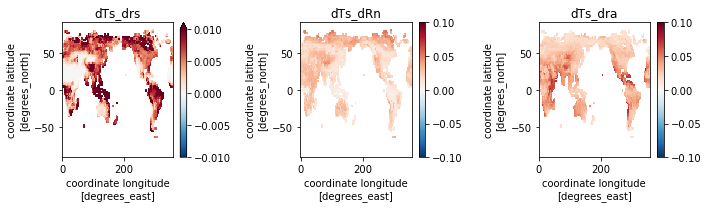

In [115]:
plt.figure(figsize=(10,3))
for i, var in enumerate(datasets):
    plt.subplot(1,3,i+1)
    if i==0:
        var.plot(vmin=-0.01,vmax=0.01, cmap=plt.cm.RdBu_r)
    else:
        var.plot(vmin=-0.1,vmax=0.1, cmap=plt.cm.RdBu_r)
    plt.title(labels[i])
    
        
plt.tight_layout()

# Idealized responses

In [32]:
[Ts_est_ref, SH_est_ref, LH_est_ref]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref,
                                                                       rs_ref,
                                                                       albedo_ref)

[Ts_ra_perturb, SH_ra_perturb, LH_ra_perturb]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref+20,
                                                                       rs_ref,
                                                                       albedo_ref)

[Ts_rs_perturb, SH_rs_perturb, LH_rs_perturb]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref,
                                                                       rs_ref+150,
                                                                       albedo_ref)

albedo_new=(albedo_ref-0.142)
albedo_new=albedo_new.where(albedo_new>0,0).where(~np.isnan(albedo_ref))
[Ts_albedo_perturb, SH_albedo_perturb, LH_albedo_perturb]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref,
                                                                       rs_ref,
                                                                       albedo_new)

In [33]:
[Ts_est_ref, SH_est_ref, LH_est_ref]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref.mean(dim='time'),
                                                                       rs_ref.mean(dim='time'),
                                                                       albedo_ref.mean(dim='time'))

[Ts_ra_perturb, SH_ra_perturb, LH_ra_perturb]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref.mean(dim='time')+20,
                                                                       rs_ref.mean(dim='time'),
                                                                       albedo_ref.mean(dim='time'))

[Ts_rs_perturb, SH_rs_perturb, LH_rs_perturb]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref.mean(dim='time'),
                                                                       rs_ref.mean(dim='time')+138,
                                                                       albedo_ref.mean(dim='time'))

albedo_new=(albedo_ref.mean(dim='time')-0.142)
albedo_new=albedo_new.where(albedo_new>0,0).where(~np.isnan(albedo_ref))
[Ts_albedo_perturb, SH_albedo_perturb, LH_albedo_perturb]=solve_surf_energy_budget(met_ref, 
                                                                       ra_ref.mean(dim='time'),
                                                                       rs_ref.mean(dim='time'),
                                                                       albedo_new)

In [34]:
#about 20, array(20.540044)
delta_ra_for_1deg=1/(dTs_dra.mean(dim='time')*landweights).mean(dim=['lat','lon']).load()

#about 138, array(138.460825)
delta_rs_for_1deg=1/(dTs_drs.mean(dim='time')*landweights).mean(dim=['lat','lon']).load()

#about 0.14, array(0.141924)
delta_albedo_for_1deg=1/((met_ref.SWin*dTs_dRn).mean(dim='time')*landweights).mean(dim=['lat','lon']).load()

In [35]:
Ts_delta_rs_avg=(Ts_rs_perturb-Ts_est_ref).mean(dim='time').load()
SH_rs_perturb_avg=(SH_rs_perturb).mean(dim='time').load()
LH_rs_perturb_avg=(LH_rs_perturb).mean(dim='time').load()
EF_rs_perturb_avg=LH_rs_perturb_avg/(LH_rs_perturb_avg+SH_rs_perturb_avg)

In [36]:
Ts_delta_ra_avg=(Ts_ra_perturb-Ts_est_ref).mean(dim='time').load()
Ts_delta_rs_avg=(Ts_rs_perturb-Ts_est_ref).mean(dim='time').load()
Ts_delta_albedo_avg=(Ts_albedo_perturb-Ts_est_ref).mean(dim='time').load()

SH_albedo_perturb_avg=(SH_albedo_perturb).mean(dim='time').load()
SH_rs_perturb_avg=(SH_rs_perturb).mean(dim='time').load()
SH_ra_perturb_avg=(SH_ra_perturb).mean(dim='time').load()
SH_est_ref_avg=SH_est_ref.mean(dim='time').load()

LH_albedo_perturb_avg=(LH_albedo_perturb).mean(dim='time').load()
LH_rs_perturb_avg=(LH_rs_perturb).mean(dim='time').load()
LH_ra_perturb_avg=(LH_ra_perturb).mean(dim='time').load()
LH_est_ref_avg=LH_est_ref.mean(dim='time').load()


KeyboardInterrupt



In [ ]:
EF_albedo_perturb_avg=LH_albedo_perturb_avg/(LH_albedo_perturb_avg+SH_albedo_perturb_avg)
EF_rs_perturb_avg=LH_rs_perturb_avg/(LH_rs_perturb_avg+SH_rs_perturb_avg)
EF_ra_perturb_avg=LH_ra_perturb_avg/(LH_ra_perturb_avg+SH_ra_perturb_avg)
EF_est_ref_avg=LH_est_ref_avg/(LH_est_ref_avg+SH_est_ref_avg)

In [ ]:
vmax=1.0
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
Ts_delta_ra_avg.plot(vmin=-vmax,vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('ra')
plt.subplot(1,3,2)
Ts_delta_rs_avg.plot(vmin=-vmax,vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('rs')
plt.subplot(1,3,3)
Ts_delta_albedo_avg.plot(vmin=-vmax,vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('albedo')
plt.tight_layout()

In [86]:
print((Ts_delta_ra_avg*landweights).mean(dim=['lat','lon']).values)
print((Ts_delta_rs_avg*landweights).mean(dim=['lat','lon']).values)
print((Ts_delta_albedo_avg*landweights).mean(dim=['lat','lon']).values)

0.6161328
0.29894865
0.8815826


In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
(LH_ra_perturb_avg-LH_est_ref_avg).plot(vmax=50, vmin=-50, cmap=plt.cm.BrBG)
plt.title('ra')
plt.subplot(1,3,2)
(LH_rs_perturb_avg-LH_est_ref_avg).plot(vmax=50, vmin=-50, cmap=plt.cm.BrBG)
plt.title('rs')
plt.subplot(1,3,3)
(LH_albedo_perturb_avg-LH_est_ref_avg).plot(vmax=50, vmin=-50, cmap=plt.cm.BrBG)
plt.title('albedo')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
(SH_ra_perturb_avg-SH_est_ref_avg).plot(vmax=50, vmin=-50, cmap=plt.cm.bwr)
plt.title('ra')
plt.subplot(1,3,2)
(SH_rs_perturb_avg-SH_est_ref_avg).plot(vmax=50, vmin=-50, cmap=plt.cm.bwr)
plt.title('rs')
plt.subplot(1,3,3)
(SH_albedo_perturb_avg-SH_est_ref_avg).plot(vmax=50, vmin=-50, cmap=plt.cm.bwr)
plt.title('albedo')
plt.tight_layout()

In [ ]:
vmax=0.4
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
(EF_ra_perturb_avg-EF_est_ref_avg).plot(vmax=vmax, cmap=plt.cm.PuOr)
plt.title('ra')
plt.subplot(1,3,2)
(EF_rs_perturb_avg-EF_est_ref_avg).plot(vmax=vmax, cmap=plt.cm.PuOr)
plt.title('rs')
plt.subplot(1,3,3)
(EF_albedo_perturb_avg-EF_est_ref_avg).plot(vmax=vmax, cmap=plt.cm.PuOr)
plt.title('albedo')
plt.tight_layout()

In [90]:
EF_avg_rs=(LH_rs_perturb_avg*landweights).mean(dim=['lat','lon'])/(
    (LH_rs_perturb_avg*landweights).mean(dim=['lat','lon'])+
    (SH_rs_perturb_avg*landweights).mean(dim=['lat','lon'])
)

EF_avg_ra=(LH_ra_perturb_avg*landweights).mean(dim=['lat','lon'])/(
    (LH_ra_perturb_avg*landweights).mean(dim=['lat','lon'])+
    (SH_ra_perturb_avg*landweights).mean(dim=['lat','lon'])
)

EF_avg_albedo=(LH_albedo_perturb_avg*landweights).mean(dim=['lat','lon'])/(
    (LH_albedo_perturb_avg*landweights).mean(dim=['lat','lon'])+
    (SH_albedo_perturb_avg*landweights).mean(dim=['lat','lon'])
)

EF_avg_ref=(LH_est_ref_avg*landweights).mean(dim=['lat','lon'])/(
    (LH_est_ref_avg*landweights).mean(dim=['lat','lon'])+
    (SH_est_ref_avg*landweights).mean(dim=['lat','lon'])
)

In [91]:
EF_delta_albedo=EF_avg_albedo-EF_avg_ref
EF_delta_ra=EF_avg_ra-EF_avg_ref
EF_delta_rs=EF_avg_rs-EF_avg_ref

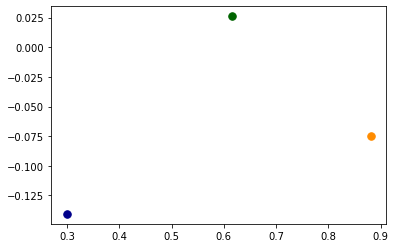

In [92]:
plt.plot((Ts_delta_albedo_avg*landweights).mean(dim=['lat','lon']),
         EF_delta_albedo,'.',markersize=15,
        color='darkorange',label='albedo')
plt.plot((Ts_delta_rs_avg*landweights).mean(dim=['lat','lon']),
         EF_delta_rs,'.',markersize=15,
        color='darkblue',label='rs')
plt.plot((Ts_delta_ra_avg*landweights).mean(dim=['lat','lon']),
         EF_delta_ra,'.',markersize=15,
        color='darkgreen',label='ra')

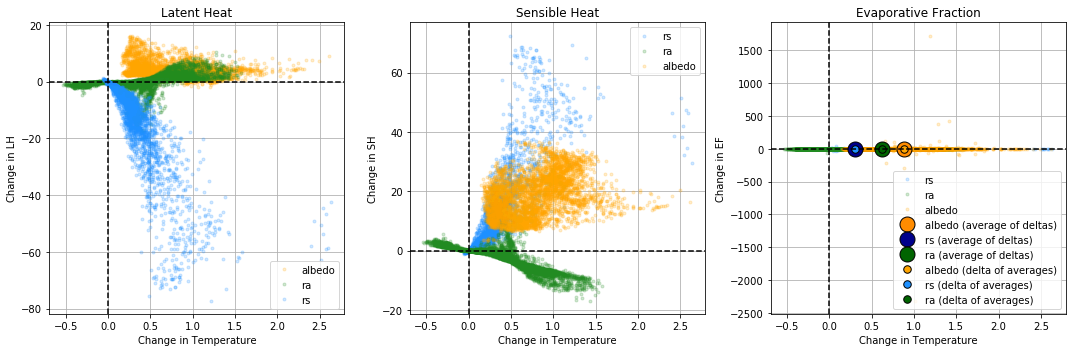

In [93]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(Ts_delta_albedo_avg.values.flatten(),
         (LH_albedo_perturb_avg-LH_est_ref_avg).values.flatten(),'.',alpha=0.2,
        color='orange',label='albedo')
plt.plot(Ts_delta_ra_avg.values.flatten(),
         (LH_ra_perturb_avg-LH_est_ref_avg).values.flatten(),'.', alpha=0.2,color='forestgreen',label='ra')
plt.plot(Ts_delta_rs_avg.values.flatten(),
         (LH_rs_perturb_avg-LH_est_ref_avg).values.flatten(),'.', alpha=0.2,color='dodgerblue',label='rs')
plt.xlabel('Change in Temperature')
plt.ylabel('Change in LH')
plt.grid()
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
plt.title('Latent Heat')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Ts_delta_rs_avg.values.flatten(),
         (SH_rs_perturb_avg-SH_est_ref_avg).values.flatten(),'.', alpha=0.2,color='dodgerblue',label='rs')
plt.plot(Ts_delta_ra_avg.values.flatten(),
         (SH_ra_perturb_avg-SH_est_ref_avg).values.flatten(),'.', alpha=0.2,color='forestgreen',label='ra')
plt.plot(Ts_delta_albedo_avg.values.flatten(),
         (SH_albedo_perturb_avg-SH_est_ref_avg).values.flatten(),'.',alpha=0.2,
        color='orange',label='albedo')
plt.xlabel('Change in Temperature')
plt.ylabel('Change in SH')
plt.grid()
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
plt.title('Sensible Heat')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Ts_delta_rs_avg.values.flatten(),
         (EF_rs_perturb_avg-EF_est_ref_avg).values.flatten(),'.', alpha=0.2,color='dodgerblue',label='rs')
plt.plot(Ts_delta_ra_avg.values.flatten(),
         (EF_ra_perturb_avg-EF_est_ref_avg).values.flatten(),'.', alpha=0.2,color='forestgreen',label='ra')
plt.plot(Ts_delta_albedo_avg.values.flatten(),
         (EF_albedo_perturb_avg-EF_est_ref_avg).values.flatten(),'.',alpha=0.2,
        color='orange',label='albedo')

plt.plot((Ts_delta_albedo_avg*landweights).mean(dim=['lat','lon']),
         ((EF_albedo_perturb_avg-EF_est_ref_avg)*landweights).mean(dim=['lat','lon']),
         'o',markersize=15,markeredgecolor='k',
        color='darkorange',label='albedo (average of deltas)')
plt.plot((Ts_delta_rs_avg*landweights).mean(dim=['lat','lon']),
         ((EF_rs_perturb_avg-EF_est_ref_avg)*landweights).mean(dim=['lat','lon']),'o',
         markersize=15,markeredgecolor='k',
        color='darkblue',label='rs (average of deltas)')
plt.plot((Ts_delta_ra_avg*landweights).mean(dim=['lat','lon']),
         ((EF_ra_perturb_avg-EF_est_ref_avg)*landweights).mean(dim=['lat','lon']),
         'o',markersize=15,markeredgecolor='k',
        color='darkgreen',label='ra (average of deltas)')

plt.plot((Ts_delta_albedo_avg*landweights).mean(dim=['lat','lon']),
         EF_delta_albedo,'.',markersize=15,markeredgecolor='k',
        color='orange',label='albedo (delta of averages)')
plt.plot((Ts_delta_rs_avg*landweights).mean(dim=['lat','lon']),
         EF_delta_rs,'.',markersize=15,markeredgecolor='k',
        color='dodgerblue',label='rs (delta of averages)')
plt.plot((Ts_delta_ra_avg*landweights).mean(dim=['lat','lon']),
         EF_delta_ra,'.',markersize=15,markeredgecolor='k',
        color='darkgreen',label='ra (delta of averages)')

plt.xlabel('Change in Temperature')
plt.ylabel('Change in EF')
plt.grid()
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
plt.legend()
plt.title('Evaporative Fraction')
plt.tight_layout()

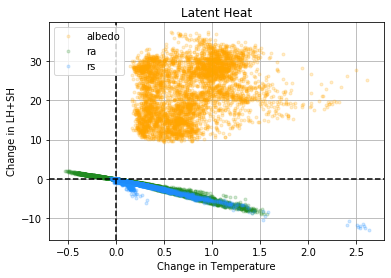

In [94]:

plt.plot(Ts_delta_albedo_avg.values.flatten(),
         (LH_albedo_perturb_avg+
          SH_albedo_perturb_avg-
          LH_est_ref_avg-
          SH_est_ref_avg
         ).values.flatten(),'.',alpha=0.2,
        color='orange',label='albedo')
plt.plot(Ts_delta_ra_avg.values.flatten(),
         (LH_ra_perturb_avg+
          SH_ra_perturb_avg-
          LH_est_ref_avg-
          SH_est_ref_avg).values.flatten(),'.', alpha=0.2,color='forestgreen',label='ra')
plt.plot(Ts_delta_rs_avg.values.flatten(),
         (LH_rs_perturb_avg+
          SH_rs_perturb_avg-
          LH_est_ref_avg-
          SH_est_ref_avg).values.flatten(),'.', alpha=0.2,color='dodgerblue',label='rs')
plt.xlabel('Change in Temperature')
plt.ylabel('Change in LH+SH')
plt.grid()
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
plt.title('Latent Heat')
plt.legend()

# Load parameter perturbation data

In [42]:
def get_data(key,
             spin_up_yr=spin_up_yr,
             ensemble_dir='offline_simulations'):
    """"Load parameter perturbation data
    Variables needed: TBOT, QBOT, PBOT, FSDS, FLDS, EFLX_LH_TOT, FSH, TSKIN, FSA, FIRA, FIRE
    """
    ds_Ta=get_dataset(ensemble_dir=ensemble_dir,var='TBOT', key=key)['TBOT'][spin_up_yr*12:,:,:]
    ds_qa=get_dataset(ensemble_dir=ensemble_dir,var='QBOT', key=key)['QBOT'][spin_up_yr*12:,:,:]
    ds_P=get_dataset(ensemble_dir=ensemble_dir,var='PBOT', key=key)['PBOT'][spin_up_yr*12:,:,:]
    ds_FSDS=get_dataset(ensemble_dir=ensemble_dir,var='FSDS', key=key)['FSDS'][spin_up_yr*12:,:,:]
    ds_FLDS=get_dataset(ensemble_dir=ensemble_dir,var='FLDS', key=key)['FLDS'][spin_up_yr*12:,:,:]

    #ds_Ta=ds_Ta_ref
    met=met_driver_data(ds_FSDS, ds_FLDS, ds_Ta, ds_qa, ds_P)
    
    met_seasonal=met_driver_data(ds_FSDS.groupby('time.month').mean(dim='time'), 
                                 ds_FLDS.groupby('time.month').mean(dim='time'), 
                                 ds_Ta.groupby('time.month').mean(dim='time'), 
                                 ds_qa.groupby('time.month').mean(dim='time'), 
                                 ds_P.groupby('time.month').mean(dim='time'))
    
    ### Ensemble member
    LH=get_dataset(ensemble_dir=ensemble_dir,var='EFLX_LH_TOT', key=key)['EFLX_LH_TOT'][spin_up_yr*12:,:,:]
    SH=get_dataset(ensemble_dir=ensemble_dir,var='FSH', key=key)['FSH'][spin_up_yr*12:,:,:]
    Ts=get_dataset(ensemble_dir=ensemble_dir,var='TSKIN', key=key)['TSKIN'][spin_up_yr*12:,:,:]

    FSA=get_dataset(ensemble_dir=ensemble_dir,var='FSA', key=key)['FSA'][spin_up_yr*12:,:,:]
    FIRA=get_dataset(ensemble_dir=ensemble_dir,var='FIRA', key=key)['FIRA'][spin_up_yr*12:,:,:]
    FIRE=get_dataset(ensemble_dir=ensemble_dir,var='FIRE', key=key)['FIRE'][spin_up_yr*12:,:,:]
    
    return [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]

In [61]:
def calculate_deltas(Rnet, ra, rs, Ts, 
                     Rnet_ref=Rnet_ref, ra_ref=ra_ref, rs_ref=rs_ref, Ts_ref=Ts_ref,
                     method='method1'):
    if method=='method1':
        """Calculate changes in land surface properties"""
        # VERSION 1
        delta_Rnet=(Rnet-Rnet_ref).load()
        delta_ra=(ra-ra_ref).load()
        delta_rs=(rs-rs_ref).load()
        delta_Ts=(Ts-Ts_ref).load()

        #delta_Rnet_seasonal=delta_Rnet.groupby('time.month').mean(dim='time').load()
        #delta_ra_seasonal=delta_ra.groupby('time.month').mean(dim='time').load()
        #delta_rs_seasonal=delta_rs.groupby('time.month').mean(dim='time').load()
        #delta_Ts_seasonal=delta_Ts.groupby('time.month').mean(dim='time').load()
        
        timedim='time'
        return [delta_Rnet, delta_ra, delta_rs, delta_Ts, timedim]
    
    elif method=='method2':
        delta_Rnet=(Rnet.load().median(dim='time')-Rnet_ref.load().median(dim='time').load())
        delta_ra=(ra.load().median(dim='time').load()-ra_ref.load().median(dim='time').load()).load()
        delta_rs=(rs.load().median(dim='time').load()-rs_ref.load().median(dim='time').load()).load()
        delta_Ts=(Ts.load().median(dim='time').load()-Ts_ref.load().median(dim='time').load()).load()
        
        timedim='time'
        return [delta_Rnet, delta_ra, delta_rs, delta_Ts, timedim]
        
    elif method=='method2':
        delta_Rnet_seasonal=(Rnet.groupby('time.month').mean(dim='time')-
            Rnet_ref.groupby('time.month').mean(dim='time')).load()

        delta_ra_seasonal=(ra.groupby('time.month').mean(dim='time')-
            ra_ref.groupby('time.month').mean(dim='time')).load()

        delta_rs_seasonal=(rs.groupby('time.month').mean(dim='time')-
            rs_ref.groupby('time.month').mean(dim='time')).load()

        delta_Ts_seasonal=(Ts.groupby('time.month').mean(dim='time')-
            Ts_ref.groupby('time.month').mean(dim='time')).load()
        
        timedim='month'
        
        return [delta_Rnet_seasonal, delta_ra_seasonal, delta_rs_seasonal, delta_Ts_seasonal, timedim]
        
    

In [44]:
def calculate_deltas_coupled(Ta,met,
                     Rnet_ref=Rnet_ref, ra_ref=ra_ref, rs_ref=rs_ref, Ts_ref=Ts_ref,
                     method='method1'):
    if method=='method1':
        """Calculate changes in land surface properties"""
        # VERSION 1
        qdiff=met.qsat_Ta-met.qa
        
        qdiff_ref=met_ref.qsat_Ta-met_ref.qa
        delta_Ta=(Ta-Ta_ref).load()
        delta_qa=(met.qa-met_ref.qa).load()
        delta_qsat_Ta=(met.qsat_Ta-met_ref.qsat_Ta).load()
        delta_qdiff=(qdiff-qdiff_ref).load()

        #delta_Rnet_seasonal=delta_Rnet.groupby('time.month').mean(dim='time').load()
        #delta_ra_seasonal=delta_ra.groupby('time.month').mean(dim='time').load()
        #delta_rs_seasonal=delta_rs.groupby('time.month').mean(dim='time').load()
        #delta_Ts_seasonal=delta_Ts.groupby('time.month').mean(dim='time').load()
        
        timedim='time'
        return [delta_Rnet, delta_ra, delta_rs, delta_Ts, timedim]
        
        return [delta_Rnet_seasonal, delta_ra_seasonal, delta_rs_seasonal, delta_Ts_seasonal, timedim]
        
    

In [45]:
def calculate_temperature_changes(dTs_dRn,
                                  dTs_dra,
                                  dTs_drs,
                                  delta_Rnet,
                                  delta_Ra,
                                  delta_rs,
                                  delta_Ts,
                                  method='method1'):
    """Calculate temperature changes due to changes in each land surface property"""
    
    
    dTs_Rnet=(dTs_dRn*delta_Rnet).load()
    dTs_ra=(dTs_dra*delta_ra).load()
    dTs_rs=(dTs_drs*delta_rs).load()
    dTs_est=dTs_Rnet+dTs_ra+dTs_rs#+delta_Ts_secondorder
    dTs_actual=delta_Ts#_seasonal#.mean(dim='time').load()
    error=dTs_est-dTs_actual
        
    if method=='method1':
        # VERSION 1: inputs were for each timestep        
        dTs_Rnet_avg=dTs_Rnet.mean(dim='time')
        dTs_ra_avg=dTs_ra.mean(dim='time')
        dTs_rs_avg=dTs_rs.mean(dim='time')
        dTs_est_avg=dTs_est.mean(dim='time')
        dTs_actual_avg=dTs_actual.mean(dim='time')
        error_avg=error.mean(dim='time')

    elif method=='method2':
        # VERSION 2: inputs were averaged by month
        
        dTs_Rnet_avg=dTs_Rnet.mean(dim='month')
        dTs_ra_avg=dTs_ra.mean(dim='month')
        dTs_rs_avg=dTs_rs.mean(dim='month')
        dTs_est_avg=dTs_est.mean(dim='month')
        dTs_actual_avg=dTs_actual.mean(dim='month')
        error_avg=error.mean(dim='month')
    
    elif method=='method3':
        # VERSION 3: inputs were annual averages
        dTs_Rnet_avg=dTs_Rnet.load()
        dTs_ra_avg=dTs_ra.load()
        dTs_rs_avg=dTs_rs.load()

        dTs_est_avg=dTs_Rnet_avg+dTs_ra_avg+dTs_rs_avg
        dTs_actual_avg=delta_Ts_seasonal.mean(dim='month').load()
        error_avg=dTs_est_avg-dTs_actual_avg
        
    return [dTs_Rnet_avg, dTs_ra_avg, dTs_rs_avg, dTs_est_avg, dTs_actual_avg, error_avg]

In [107]:
for key_short in key_short_list:

    key=key_short+'_PI_v02'

    desc=(crosswalk.description.values[(crosswalk.key_landonlyPPE.values==key_short)])[0]
    print(key+': '+desc)

OFFL0001_PI_v02: rhosnir, min
OFFL0002_PI_v02: rhosnir, max
OFFL0003_PI_v02: z0mr, min
OFFL0004_PI_v02: z0mr, max
OFFL0005_PI_v02: zsno, min
OFFL0006_PI_v02: zsno, max
OFFL0007_PI_v02: d_max, min
OFFL0008_PI_v02: d_max, max
OFFL0009_PI_v02: frac_sat_soil_dsl_init, min
OFFL0010_PI_v02: frac_sat_soil_dsl_init, max
OFFL0011_PI_v02: zetamaxstable, min
OFFL0012_PI_v02: zetamaxstable, max
OFFL0013_PI_v02: maximum_leaf_wetted_fraction, min
OFFL0014_PI_v02: maximum_leaf_wetted_fraction, max
OFFL0015_PI_v02: fff, min
OFFL0016_PI_v02: fff, max
OFFL0017_PI_v02: upplim_destruct_metamorph, min
OFFL0018_PI_v02: upplim_destruct_metamorph, max
OFFL0019_PI_v02: medlynslope, max
OFFL0020_PI_v02: medlynintercept, min
OFFL0021_PI_v02: tpu25ratio, min
OFFL0022_PI_v02: tpu25ratio, max
OFFL0023_PI_v02: jmaxb0, max
OFFL0024_PI_v02: jmaxb1, min
OFFL0025_PI_v02: jmaxb1, max
OFFL0026_PI_v02: kmax, min
OFFL0027_PI_v02: kmax, max
OFFL0028_PI_v02: nstem, min
OFFL0029_PI_v02: nstem, max
OFFL0030_PI_v02: lmrha, min
O

In [112]:
### Load simulation data

output_dir='/glade/work/czarakas/Lague_kernels/TRM/'
save_output=True
key_short_list=['OFFL0001','OFFL0002','OFFL0003','OFFL0004','OFFL0005','OFFL0006', 
                'OFFL0007','OFFL0008','OFFL0009','OFFL0010','OFFL0011','OFFL0012',
                'OFFL0013','OFFL0014','OFFL0015','OFFL0016','OFFL0017','OFFL0018',
                'OFFL0019','OFFL0020','OFFL0021','OFFL0022','OFFL0023','OFFL0024',
                'OFFL0025','OFFL0026','OFFL0027','OFFL0028','OFFL0029','OFFL0030',
                'OFFL0031','OFFL0032','OFFL0033','OFFL0034','OFFL0035','OFFL0036']

for key_short in key_short_list:

    key=key_short+'_PI_v02'

    desc=(crosswalk.description.values[(crosswalk.key_landonlyPPE.values==key_short)])[0]
    print(key+': '+desc)

    ###---------------- Get data

    [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]=get_data(key)
    met=met_ref

    ###---------------- Calculate new variables
    print('>> Calculating new variables')
    albedo=calculate_albedo(met.SWin, FSA)
    emissivity=calculate_emissivity(FIRE, Ts, sigma=CONSTANT_sigma)
    Rnet=calculate_Rn_star(met.SWin, albedo, met.LWin, emissivity_ref, met.Ta)
    Rnet_exact=calculate_Rnet(FSA, FIRA)
    G=calculate_G(Rnet_exact, SH, LH)

    met.calculate_other_params()

    ra=calculate_ra(Ts, met.Ta, SH, met.P, met.qa)
    ra=ra.where(ra>0).load()
    rs=calculate_rs(Ts, met.Ta, met.qa, LH, ra, met.P)
    rs=rs.where(rs>0).load()
    f=calculate_f(met.ro, ra, rs, met.delta, met.gamma).load()

    ###---------------- Calculate deltas
    print('>> Calculating deltas in ra, rs, Rnet')
    [delta_Rnet, delta_ra, delta_rs, delta_Ts, timedim]=calculate_deltas(Rnet,
                                                                         ra,
                                                                         rs,
                                                                         Ts,
                                                                        method='method2')

    delta_Rnet_avg=delta_Rnet#.mean(dim=timedim).load()
    delta_ra_avg=delta_ra#.mean(dim=timedim).load()
    delta_rs_avg=delta_rs#.mean(dim=timedim).load()
    delta_Ts_avg=delta_Ts#.mean(dim=timedim).load()
    
    #if key not in ['OFFL0011_PI_v02','OFFL0012_PI_v02','OFFL0017_PI_v02','OFFL0018_PI_v02',
    #              'OFFL0005_PI_v02','OFFL0006_PI_v02']
    delta_rs_avg=delta_rs_avg.where(glc_frac<0.95,0).where(~np.isnan(landfrac))
    
    ###---------------- Saving output
    if save_output:
        print('>> Saving output')
        delta_Rnet_avg.to_dataset(name='delta_Rnet_avg').to_netcdf(output_dir+'delta_Rnet_avg.'+key+'.nc')
        delta_ra_avg.to_dataset(name='delta_ra_avg').to_netcdf(output_dir+'delta_ra_avg.'+key+'.nc')
        delta_rs_avg.to_dataset(name='delta_rs_avg').to_netcdf(output_dir+'delta_rs_avg.'+key+'.nc')
        delta_Ts_avg.to_dataset(name='delta_Ts_avg').to_netcdf(output_dir+'delta_Ts_avg.'+key+'.nc')

OFFL0001_PI_v02: rhosnir, min
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0002_PI_v02: rhosnir, max
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0003_PI_v02: z0mr, min
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0004_PI_v02: z0mr, max
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0005_PI_v02: zsno, min
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0006_PI_v02: zsno, max
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0007_PI_v02: d_max, min
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0008_PI_v02: d_max, max
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
1
>> Saving output
OFFL0009_PI_v02: frac_sat_soil_dsl_init, min
>> Calculating new variables
>> Calculating

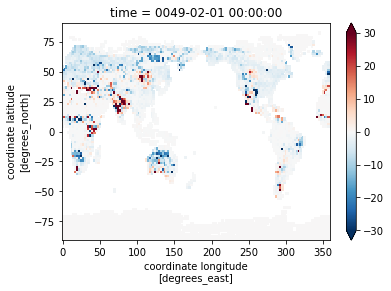

In [114]:
delta_rs_avg.plot(vmax=30)

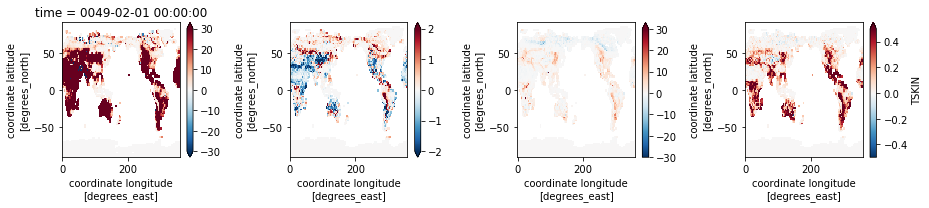

In [100]:
plt.figure(figsize=(13,3))
plt.subplot(1,4,1)
delta_rs.plot(vmax=30)
plt.subplot(1,4,2)
delta_Rnet.plot(vmax=2)
plt.subplot(1,4,3)
delta_ra.plot(vmax=30)
plt.subplot(1,4,4)
delta_Ts_avg.plot(vmax=0.5)
plt.tight_layout()

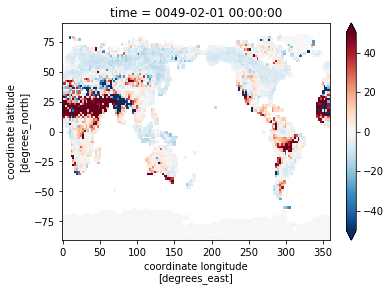

In [34]:
### Load simulation data

output_dir='/glade/work/czarakas/Lague_kernels/TRM/'
save_output=False
key_short_list=['OFFL0011',#'OFFL0001','OFFL0002','OFFL0003','OFFL0004','OFFL0005','OFFL0006', 
                #'OFFL0007','OFFL0008','OFFL0009','OFFL0010','OFFL0011','OFFL0012',
                #'OFFL0013','OFFL0014','OFFL0015','OFFL0016','OFFL0017','OFFL0018',
                #'OFFL0019','OFFL0020','OFFL0021','OFFL0022','OFFL0023','OFFL0024',
                'OFFL0025','OFFL0026','OFFL0027','OFFL0028','OFFL0029','OFFL0030',
                'OFFL0031','OFFL0032','OFFL0033','OFFL0034','OFFL0035','OFFL0036']

for key_short in key_short_list[0:1]:

    key=key_short+'_PI_v02'

    desc=(crosswalk.description.values[(crosswalk.key_landonlyPPE.values==key_short)])[0]
    print(key+': '+desc)

    ###---------------- Get data

    [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]=get_data(key)
    met=met_ref

    ###---------------- Calculate new variables
    print('>> Calculating new variables')
    albedo=calculate_albedo(met.SWin, FSA)
    emissivity=calculate_emissivity(FIRE, Ts, sigma=CONSTANT_sigma)
    Rnet=calculate_Rn_star(met.SWin, albedo, met.LWin, emissivity_ref, met.Ta)
    Rnet_exact=calculate_Rnet(FSA, FIRA)
    G=calculate_G(Rnet_exact, SH, LH)

    met.calculate_other_params()

    ra=calculate_ra(Ts, met.Ta, SH, met.P, met.qa)
    ra=ra.where(ra>0).load()
    rs=calculate_rs(Ts, met.Ta, met.qa, LH, ra, met.P)
    rs=rs.where(rs>0).load()
    f=calculate_f(met.ro, ra, rs, met.delta, met.gamma).load()

    ###---------------- Calculate deltas
    print('>> Calculating deltas in ra, rs, Rnet')
    [delta_Rnet, delta_ra, delta_rs, delta_Ts, timedim]=calculate_deltas(Rnet,
                                                                         ra,
                                                                         rs,
                                                                         Ts)

    delta_Rnet_avg=delta_Rnet.mean(dim=timedim).load()
    delta_ra_avg=delta_ra.mean(dim=timedim).load()
    delta_rs_avg=delta_rs.mean(dim=timedim).load()
    delta_Ts_avg=delta_Ts.mean(dim=timedim).load()
    
    ###---------------- Calculate temperature deltas
    print('>> Calculating temperature changes')
    [dTs_Rnet_avg, 
     dTs_ra_avg, 
     dTs_rs_avg, 
     dTs_est_avg, 
     dTs_actual_avg, 
     error_avg] = calculate_temperature_changes(dTs_dRn,
                                                dTs_dra,
                                                dTs_drs,
                                                delta_Rnet,
                                                delta_ra,
                                                delta_rs,
                                                delta_Ts)
    
    
    ###---------------- Saving output
    if save_output:
        print('>> Saving output')
        delta_Rnet_avg.to_dataset(name='delta_Rnet_avg').to_netcdf(output_dir+'delta_Rnet_avg.'+key+'.nc')
        delta_ra_avg.to_dataset(name='delta_ra_avg').to_netcdf(output_dir+'delta_ra_avg.'+key+'.nc')
        delta_rs_avg.to_dataset(name='delta_rs_avg').to_netcdf(output_dir+'delta_rs_avg.'+key+'.nc')
        delta_Ts_avg.to_dataset(name='delta_Ts_avg').to_netcdf(output_dir+'delta_Ts_avg.'+key+'.nc')
        dTs_Rnet_avg.to_dataset(name='dTs_Rnet_avg').to_netcdf(output_dir+'dTs_Rnet_avg.'+key+'.nc')
        dTs_ra_avg.to_dataset(name='dTs_ra_avg').to_netcdf(output_dir+'dTs_ra_avg.'+key+'.nc')
        dTs_rs_avg.to_dataset(name='dTs_rs_avg').to_netcdf(output_dir+'dTs_rs_avg.'+key+'.nc')
        dTs_est_avg.to_dataset(name='dTs_est_avg').to_netcdf(output_dir+'dTs_est_avg.'+key+'.nc')
        dTs_actual_avg.to_dataset(name='dTs_actual_avg').to_netcdf(output_dir+'dTs_actual_avg.'+key+'.nc')
        error_avg.to_dataset(name='error_avg').to_netcdf(output_dir+'error_avg.'+key+'.nc')

OFFL0011_PI_v02: zetamaxstable, min
>> Calculating new variables
>> Calculating deltas in ra, rs, Rnet
>> Calculating temperature changes


In [ ]:
(dTs_drs.mean(dim='time')*delta_rs_avg).plot(vmax=0.3)

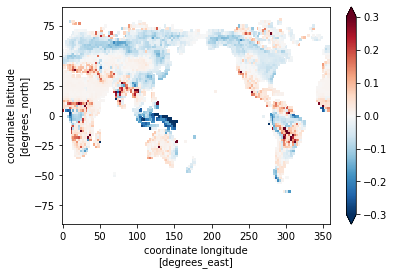

In [56]:
(dTs_drs.mean(dim='time')*delta_rs_avg).plot(vmax=0.3)

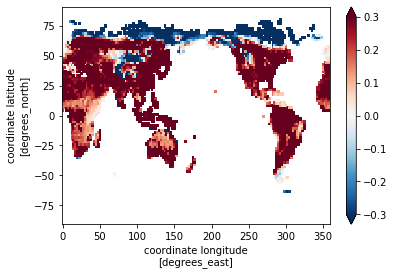

In [55]:
(dTs_dra.mean(dim='time')*delta_ra_avg).plot(vmax=0.3)

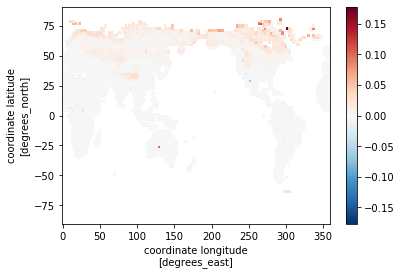

In [54]:
(dTs_dRn.mean(dim='time')*delta_Rnet_avg).plot(vmax=0.3)

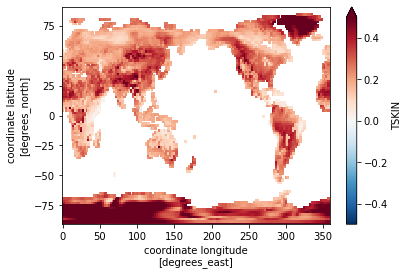

In [45]:
dTs_actual_avg.plot(vmax=0.5)

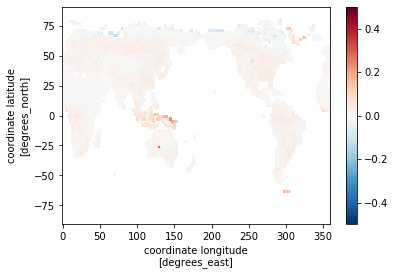

In [51]:
error_avg.plot(vmax=0.5)

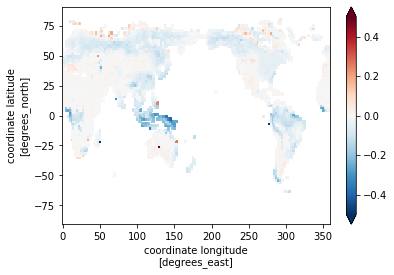

In [50]:
dTs_rs_avg.plot(vmax=0.5)

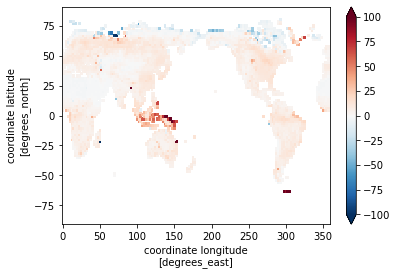

In [42]:
(error_avg*100/dTs_actual_avg).plot(vmax=100)#, cmap=plt.cm.viridis)

In [ ]:
Ts_est_ref=calculate_Ts(met_ref, Rnet_ref, ra_ref, rs_ref, G_ref)

In [171]:
Ts_est_perturb=calculate_Ts(met_ref, Rnet, ra, rs, G)
delta_Ts_est_method1=Ts_est_perturb-Ts_est_ref

In [179]:
dTs_actual_avg#=Ts_est_perturb-Ts_est_ref

<xarray.DataArray 'TSKIN' (lat: 96, lon: 144)>
array([[0.527317, 0.521986, 0.520993, ..., 0.529097, 0.528961, 0.528469],
       [0.491547, 0.497866, 0.510991, ..., 0.451589, 0.465784, 0.479654],
       [0.349101, 0.361592, 0.381011, ..., 0.311303, 0.329249, 0.342741],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0

In [180]:
error_method1=delta_Ts_est_method1.mean(dim='time')-dTs_actual_avg

In [167]:
(error_avg*landweights).mean(dim=['lat','lon']).values

array(0.01258988, dtype=float32)

In [ ]:
def calculate_Ts(met, Rn, 
                 ra, rs, 
                 G=0, 
                 Lv=CONSTANT_Lv):
    met.calculate_other_params()
    lambda0=met.lambda0
    rho=met.rho
    qdiff=met.qsat_Ta-met.qa
    Ta=met.Ta

    f=calculate_f(met.ro, ra, rs, met.delta, met.gamma)
    
    term1=(Rnet_ref-((rho*Lv/(ra+rs))*qdiff))
    Tdiff=(lambda0*term1/(1+f)).load()
    Ts=Tdiff+Ta
    return Ts

### Do the attribution

In [ ]:
delta_ra

# Try coupled case

In [203]:
def calculate_temperature_changes(dTs_dRn,
                                  dTs_dra,
                                  dTs_drs,
                                  delta_Rnet,
                                  delta_Ra,
                                  delta_rs,
                                  delta_Ts,
                                  method='method1'):
    """Calculate temperature changes due to changes in each land surface property"""
    
    
    dTs_Rnet=(dTs_dRn*delta_Rnet).load()
    dTs_ra=(dTs_dra*delta_ra).load()
    dTs_rs=(dTs_drs*delta_rs).load()
    
    # now the atmsopheric part
    qdiff=met.qsat_Ta-met.qa
    qdiff_ref=met_ref.qsat_Ta-met_ref.qa
    delta_Ta=(met.Ta-met_ref.Ta).load()
    delta_qa=(met.qa-met_ref.qa).load()
    delta_qsat_Ta=(met.qsat_Ta-met_ref.qsat_Ta).load()
    delta_qdiff=(qdiff-qdiff_ref).load()

    dTs_qdiff=dTs_dqdiff*delta_qdiff
    dTs_Ta=dTs_dTa*delta_Ta
    
    dTs_est=dTs_Rnet+dTs_ra+dTs_rs+dTs_qdiff+dTs_Ta
    dTs_actual=delta_Ts#_seasonal#.mean(dim='time').load()
    error=dTs_est-dTs_actual
        
    if method=='method1':
        # VERSION 1: inputs were for each timestep        
        dTs_Rnet_avg=dTs_Rnet.mean(dim='time')
        dTs_ra_avg=dTs_ra.mean(dim='time')
        dTs_rs_avg=dTs_rs.mean(dim='time')
        dTs_est_avg=dTs_est.mean(dim='time')
        dTs_actual_avg=dTs_actual.mean(dim='time')
        error_avg=error.mean(dim='time')
        dTs_qdiff_avg=dTs_qdiff.mean(dim='time')
        dTs_Ta_avg=dTs_Ta.mean(dim='time')
        
    return [dTs_Rnet_avg, dTs_ra_avg, dTs_rs_avg, 
            dTs_Ta_avg, dTs_qdiff_avg,
            dTs_est_avg, dTs_actual_avg, error_avg]

In [302]:
ra_ref=met_ref.rho*CONSTANT_Cp*(Ts_ref-met_ref.Ta)/SH_ref.where(np.abs(SH_ref)>5)
ra_ref_avg=ra_ref[40:,:,:].mean(dim='time').load()

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144)
Coordinates:
  * lon           (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat           (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
Data variables:
    delta_ra_avg  (lat, lon) float32 dask.array<shape=(96, 144), chunksize=(96, 144)>

In [309]:
output_dir='/glade/work/czarakas/Lague_kernels/TRM/'

for i,key_short in enumerate(crosswalk.key_landonlyPPE.values):
    print(key_short)
    key=key_short+'_PI_v02'
    
    desc=(crosswalk.description.values[(crosswalk.key_landonlyPPE.values==key_short)])[0]
    print(key+': '+desc)
    
    [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]=get_data(key,ensemble_dir='offline_simulations')
    met.Ta=met_ref.Ta

    met.calculate_other_params()
    ra_est=met.rho*CONSTANT_Cp*(Ts-met.Ta)/SH.where(np.abs(SH)>5)
    
    ra_est_avg=ra_est[40:,:,:].mean(dim='time')
    
    
    ra_avg_delta=(ra_est_avg-ra_ref_avg)
    ds_ra_avg_delta=ra_avg_delta.to_dataset('delta_ra_avg')
    
    ds_ra_avg_delta.to_netcdf(output_dir+'delta_ra_annual_avg.'+key+'.nc')

OFFL0001
OFFL0001_PI_v02: rhosnir, min
OFFL0002
OFFL0002_PI_v02: rhosnir, max
OFFL0007
OFFL0007_PI_v02: d_max, min
OFFL0008
OFFL0008_PI_v02: d_max, max
OFFL0009
OFFL0009_PI_v02: frac_sat_soil_dsl_init, min
OFFL0010
OFFL0010_PI_v02: frac_sat_soil_dsl_init, max
OFFL0013
OFFL0013_PI_v02: maximum_leaf_wetted_fraction, min
OFFL0014
OFFL0014_PI_v02: maximum_leaf_wetted_fraction, max
OFFL0015
OFFL0015_PI_v02: fff, min
OFFL0016
OFFL0016_PI_v02: fff, max
OFFL0017
OFFL0017_PI_v02: upplim_destruct_metamorph, min
OFFL0018
OFFL0018_PI_v02: upplim_destruct_metamorph, max
OFFL0019
OFFL0019_PI_v02: medlynslope, max
OFFL0020
OFFL0020_PI_v02: medlynintercept, min
OFFL0021
OFFL0021_PI_v02: tpu25ratio, min
OFFL0022
OFFL0022_PI_v02: tpu25ratio, max
OFFL0023
OFFL0023_PI_v02: jmaxb0, max
OFFL0024
OFFL0024_PI_v02: jmaxb1, min
OFFL0025
OFFL0025_PI_v02: jmaxb1, max
OFFL0026
OFFL0026_PI_v02: kmax, min
OFFL0027
OFFL0027_PI_v02: kmax, max
OFFL0028
OFFL0028_PI_v02: nstem, min
OFFL0029
OFFL0029_PI_v02: nstem, max
OF

In [310]:
key_short='OFFL0005'
key=key_short+'_PI_v02'



###---------------- Get data



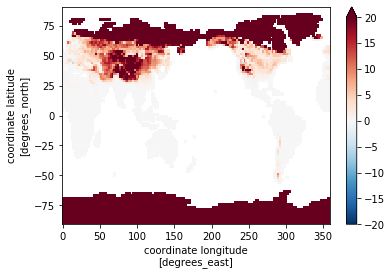

In [299]:
ra_delta=(ra_est[40*12:,:,:].mean(dim='time')-
         ra_ref[40*12:,:,:].mean(dim='time'))
ra_delta.plot(vmax=20)#vmax=100)

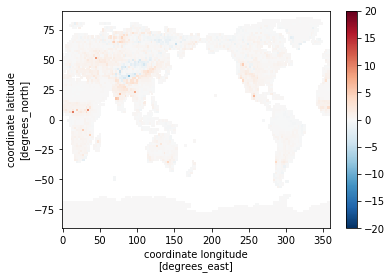

In [288]:
ra_delta=(ra_est[40*12:,:,:].mean(dim='time')-
         ra_ref[40*12:,:,:].mean(dim='time'))
ra_delta.plot(vmax=20)#vmax=100)

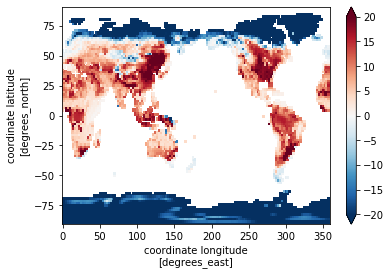

In [286]:
ra_delta=(ra_est[40*12:,:,:].mean(dim='time')-
         ra_ref[40*12:,:,:].mean(dim='time'))
ra_delta.plot(vmax=20)#vmax=100)

In [208]:
### Load simulation data

output_dir='/glade/work/czarakas/Lague_kernels/TRM/'

key_short_list=['COUP0011']

for key_short in key_short_list:

    key=key_short+'_PI_SOM_v02'

    desc=(crosswalk.description.values[(crosswalk.key_coupledPPE.values==key_short)])[0]
    print(key+': '+desc)

    ###---------------- Get data

    [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]=get_data(key,ensemble_dir='coupled_simulations')

    ###---------------- Calculate new variables
    print('>> Calculating new variables')
    albedo=calculate_albedo(met.SWin, FSA)
    emissivity=calculate_emissivity(FIRE, Ts, sigma=CONSTANT_sigma)
    Rnet=calculate_Rn_star(met.SWin, albedo, met.LWin, emissivity_ref, met.Ta)
    Rnet_exact=calculate_Rnet(FSA, FIRA)
    G=calculate_G(Rnet_exact, SH, LH)

    met.calculate_other_params()

    ra=calculate_ra(Ts, met.Ta, SH, met.P, met.qa)
    ra=ra.where(ra>0).load()
    rs=calculate_rs(Ts, met.Ta, met.qa, LH, ra, met.P)
    rs=rs.where(rs>0).load()
    f=calculate_f(met.ro, ra, rs, met.delta, met.gamma).load()

    ###---------------- Calculate deltas
    print('>> Calculating deltas in ra, rs, Rnet')
    [delta_Rnet, delta_ra, delta_rs, delta_Ts, timedim]=calculate_deltas(Rnet,
                                                                         ra,
                                                                         rs,
                                                                         Ts)

    delta_Rnet_avg=delta_Rnet.mean(dim=timedim).load()
    delta_ra_avg=delta_ra.mean(dim=timedim).load()
    delta_rs_avg=delta_rs.mean(dim=timedim).load()
    delta_Ts_avg=delta_Ts.mean(dim=timedim).load()
    
    ###---------------- Calculate temperature deltas
    print('>> Calculating temperature changes')
    [dTs_Rnet_avg, 
     dTs_ra_avg, 
     dTs_rs_avg, 
     dTs_Ta_avg, 
     dTs_qdiff_avg,
     dTs_est_avg, 
     dTs_actual_avg, 
     error_avg] = calculate_temperature_changes(dTs_dRn,
                                                dTs_dra,
                                                dTs_drs,
                                                delta_Rnet,
                                                delta_ra,
                                                delta_rs,
                                                delta_Ts)
    
    
    ###---------------- Saving output
    save_output=False
    if save_output:
        print('>> Saving output')
        delta_Rnet_avg.to_dataset(name='delta_Rnet_avg').to_netcdf(output_dir+'delta_Rnet_avg.'+key+'.nc')
        delta_ra_avg.to_dataset(name='delta_ra_avg').to_netcdf(output_dir+'delta_ra_avg.'+key+'.nc')
        delta_rs_avg.to_dataset(name='delta_rs_avg').to_netcdf(output_dir+'delta_rs_avg.'+key+'.nc')
        delta_Ts_avg.to_dataset(name='delta_Ts_avg').to_netcdf(output_dir+'delta_Ts_avg.'+key+'.nc')
        dTs_Rnet_avg.to_dataset(name='dTs_Rnet_avg').to_netcdf(output_dir+'dTs_Rnet_avg.'+key+'.nc')
        dTs_ra_avg.to_dataset(name='dTs_ra_avg').to_netcdf(output_dir+'dTs_ra_avg.'+key+'.nc')
        dTs_rs_avg.to_dataset(name='dTs_rs_avg').to_netcdf(output_dir+'dTs_rs_avg.'+key+'.nc')
        dTs_est_avg.to_dataset(name='dTs_est_avg').to_netcdf(output_dir+'dTs_est_avg.'+key+'.nc')
        dTs_actual_avg.to_dataset(name='dTs_actual_avg').to_netcdf(output_dir+'dTs_actual_avg.'+key+'.nc')
        error_avg.to_dataset(name='error_avg').to_netcdf(output_dir+'error_avg.'+key+'.nc')

COUP0011_PI_SOM_v02: zetamaxstable, min
no /glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0011_PI_SOM_v02/lnd/proc/tseries/COUP0011_PI_SOM_v02.clm2.h0.timeseries.PBOT.nc


TypeError: 'NoneType' object is not subscriptable

In [200]:
second_order_seasonal=calculate_second_order_terms(delta_Rnet_seasonal,
                                delta_ra_seasonal,
                                delta_rs_seasonal,
                                                  ra_ref,
                                                  rs_ref)
second_order_avg=second_order_seasonal.mean(dim='time').mean(dim='month').load()

# Look at where there are mostly nans based on filtering criteria

In [84]:
no_vals=(~np.isnan(rs_ref)).sum(dim='time').where(~np.isnan(met.Ta[0,:,:])).load()#.plot()
#(~np.isnan(rs_ref)).sum(dim='time').plot()

In [85]:
threshold=0.15*1680

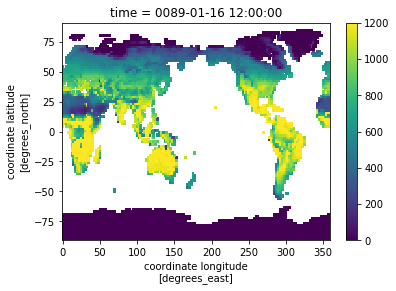

In [86]:
no_vals.plot()

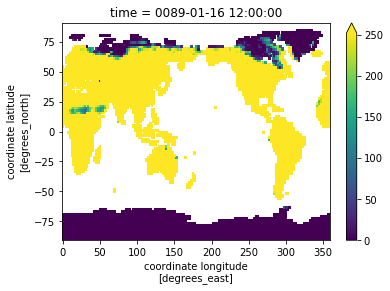

In [87]:
no_vals.plot(vmax=threshold)

# Make plots for a given simulation

### Changes in land surface properties

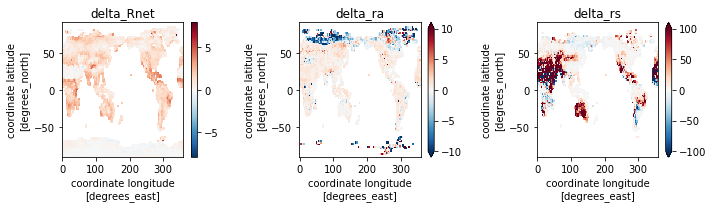

In [205]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
delta_Rnet_avg.plot(vmax=5)
plt.title('delta_Rnet')
plt.subplot(1,3,2)
delta_ra_avg.plot(vmin=-10, vmax=10, cmap=plt.cm.RdBu_r)
plt.title('delta_ra')
plt.subplot(1,3,3)
delta_rs_avg.plot(vmin=-100, vmax=100, cmap=plt.cm.RdBu_r)
plt.title('delta_rs')
plt.tight_layout()

### Temperature changes from changes in land surface properties

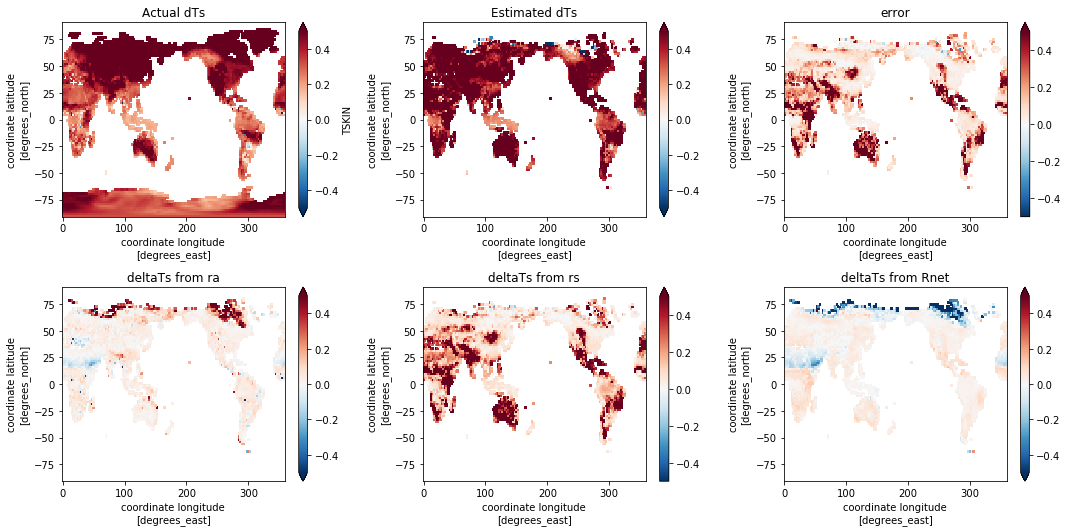

In [206]:
vmax=0.5
vmin=-vmax
plt.figure(figsize=(15,7.5))
plt.subplot(2,3,1)
dTs_actual_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('Actual dTs')

plt.subplot(2,3,2)
dTs_est_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('Estimated dTs')

plt.subplot(2,3,6)
dTs_Rnet_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from Rnet')

plt.subplot(2,3,4)
dTs_ra_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from ra')

plt.subplot(2,3,5)
dTs_rs_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from rs')

plt.subplot(2,3,3)
error_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('error')

plt.tight_layout()
plt.savefig(key+'_attribution_maps.png')

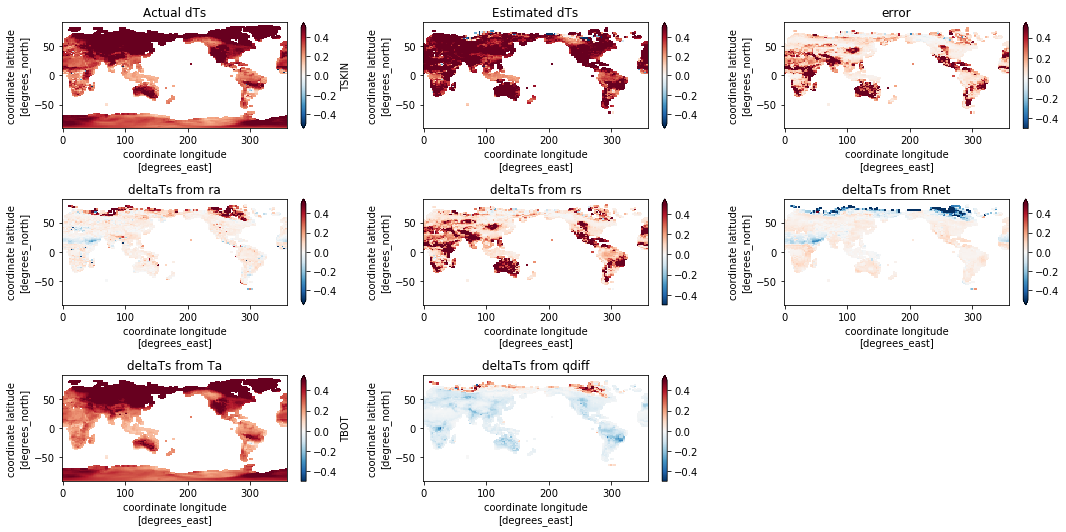

In [207]:
vmax=0.5
vmin=-vmax
plt.figure(figsize=(15,7.5))
plt.subplot(3,3,1)
dTs_actual_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('Actual dTs')

plt.subplot(3,3,2)
dTs_est_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('Estimated dTs')

plt.subplot(3,3,3)
error_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('error')

plt.subplot(3,3,6)
dTs_Rnet_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from Rnet')

plt.subplot(3,3,4)
dTs_ra_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from ra')

plt.subplot(3,3,5)
dTs_rs_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from rs')

plt.subplot(3,3,7)
dTs_Ta_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from Ta')

plt.subplot(3,3,8)
dTs_qdiff_avg.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('deltaTs from qdiff')


plt.tight_layout()
plt.savefig(key+'_attribution_maps_coupled.png')

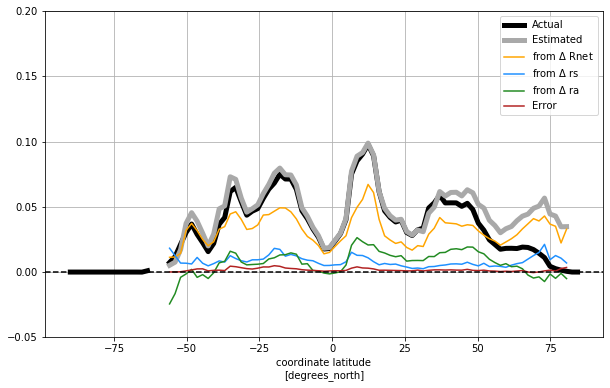

In [51]:
plt.figure(figsize=(10,6))
plt.ylim([-0.05, 0.2])
dTs_actual_avg.groupby('lat').mean(dim='lon').plot(color='k', label='Actual',linewidth=5)
dTs_est_avg.groupby('lat').mean(dim='lon').plot(color='darkgray', label='Estimated',linewidth=5)
dTs_Rnet_avg.groupby('lat').mean(dim='lon').plot(color='orange', label='from $\Delta$ Rnet')
dTs_rs_avg.groupby('lat').mean(dim='lon').plot(color='dodgerblue', label='from $\Delta$ rs')
dTs_ra_avg.groupby('lat').mean(dim='lon').plot(color='forestgreen', label='from $\Delta$ ra')
error_avg.groupby('lat').mean(dim='lon').plot(color='firebrick', label='Error')
#dTs_secondorder_avg.groupby('lat').mean(dim='lon').plot(color='aqua', label='Error')
plt.axhline(y=0,linestyle='--',color='k')
plt.legend()

plt.grid()

In [52]:
landarea_alt=landarea.where(landarea.lat<=60).where(landarea.lat>-60)
landweight_alt=landarea_alt/landarea_alt.mean(dim=['lat','lon'])

### Check global averages

In [54]:
print('Actual Temperature Change')
print((landweights*dTs_actual_avg).mean(dim=['lat','lon']).values)

print()
print('Estimated Temperature Change')
print((landweights*dTs_est_avg).mean(dim=['lat','lon']).values)

print()
print('dTs from Rnet')
print((landweights*dTs_Rnet_avg).mean(dim=['lat','lon']).values)

print()
print('dTs from ra')
print((landweights*dTs_ra_avg).mean(dim=['lat','lon']).values)

print()
print('dTs from rs')
print((landweights*dTs_rs_avg).mean(dim=['lat','lon']).values)

print()
print('Errors')
print('Error of global mean')
print(((landweights*dTs_est_avg).mean(dim=['lat','lon']).values)-
      (landweights*dTs_actual_avg).mean(dim=['lat','lon']).values)
print('Global mean of errors')
print((landweights*error_avg).mean(dim=['lat','lon']).values)

Actual Temperature Change
0.0403749

Estimated Temperature Change
0.06892122

dTs from Rnet
0.043925487

dTs from ra
0.015249198

dTs from rs
0.0097471615

Errors
Error of global mean
0.028546322
Global mean of errors
0.0023222987


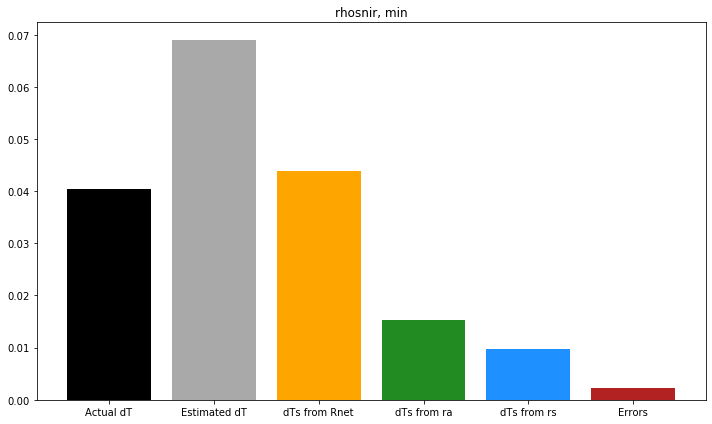

In [55]:
labels = ['Actual dT', 'Estimated dT', 'dTs from Rnet', 'dTs from ra', 'dTs from rs', 'Errors']
colors = ['black', 'darkgrey', 'orange', 'forestgreen', 'dodgerblue', 'firebrick']
dTs_array = [(landweights*dTs_actual_avg).mean(dim=['lat','lon']).values,
            (landweights*dTs_est_avg).mean(dim=['lat','lon']).values,
            (landweights*dTs_Rnet_avg).mean(dim=['lat','lon']).values,
            (landweights*dTs_ra_avg).mean(dim=['lat','lon']).values,
            (landweights*dTs_rs_avg).mean(dim=['lat','lon']).values,
            (landweights*error_avg).mean(dim=['lat','lon']).values]

plt.figure(figsize=(10,6))
plt.bar(labels,dTs_array,color=colors)
plt.title(desc)
plt.savefig(key+'_attribution.png')
plt.tight_layout()

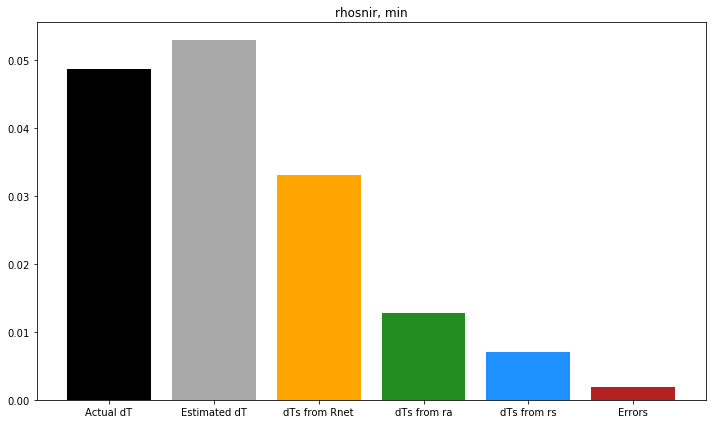

In [56]:
dTs_array = [(landweight_alt*dTs_actual_avg).mean(dim=['lat','lon']).values,
            (landweight_alt*dTs_est_avg).mean(dim=['lat','lon']).values,
            (landweight_alt*dTs_Rnet_avg).mean(dim=['lat','lon']).values,
            (landweight_alt*dTs_ra_avg).mean(dim=['lat','lon']).values,
            (landweight_alt*dTs_rs_avg).mean(dim=['lat','lon']).values,
            (landweight_alt*error_avg).mean(dim=['lat','lon']).values]

plt.figure(figsize=(10,6))
plt.bar(labels,dTs_array,color=colors)
plt.title(desc)
#plt.savefig(key+'_attribution.png')
plt.tight_layout()

# Errors (only works for not time averaged data)

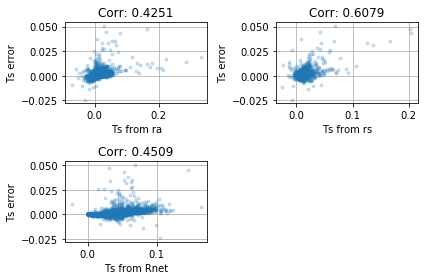

In [53]:
y_unfiltered=error_avg.values.flatten()
y=y_unfiltered[~np.isnan(y_unfiltered)]

plt.subplot(2,2,1)
x=dTs_ra_avg.values.flatten()
x=x[~np.isnan(y_unfiltered)]
plt.plot(x, y,'.', alpha=0.2)
plt.xlabel('Ts from ra')
plt.ylabel('Ts error')
plt.grid()
plt.title('Corr: '+str(np.round((np.corrcoef(x,y)[0,1]),4)))

plt.subplot(2,2,2)
x=dTs_rs_avg.values.flatten()
x=x[~np.isnan(y_unfiltered)]
plt.plot(x, y,'.', alpha=0.2)
plt.xlabel('Ts from rs')
plt.ylabel('Ts error')
plt.grid()
plt.title('Corr: '+str(np.round((np.corrcoef(x,y)[0,1]),4)))

plt.subplot(2,2,3)
x=dTs_Rnet_avg.values.flatten()
x=x[~np.isnan(y_unfiltered)]
plt.plot(x, y,'.', alpha=0.2)
plt.xlabel('Ts from Rnet')
plt.ylabel('Ts error')
plt.grid()
plt.title('Corr: '+str(np.round((np.corrcoef(x,y)[0,1]),4)))

plt.tight_layout()

#plt.plot(dTs_Rnet_avg.values.flatten(), error_avg.values.flatten(),'.')

# Look at drivers of changes in ra and rs

In [51]:
delta_SWabs=FSA[12*60:,:,:].mean(dim='time')-FSA_ref[12*60:,:,:].mean(dim='time')

In [117]:
htop=get_dataset(ensemble_dir='offline_simulations',var='HTOP', key=key)['HTOP']
htop_ref=get_dataset(ensemble_dir='offline_simulations',var='HTOP', key=key_ref)['HTOP']
htop_delta=htop-htop_ref

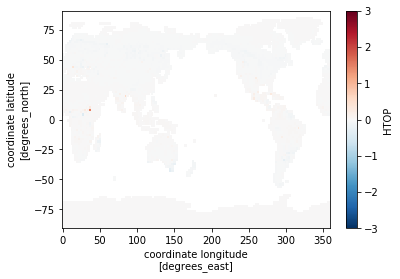

In [118]:
htop_delta.mean(dim='time').plot(vmin=-3, vmax=3, cmap=plt.cm.RdBu_r)

In [89]:
EF=LH.where(np.abs(LH)>5)/(LH+SH.where(np.abs(SH)>5)).where(ds_Ta>273.15+5)
EF_ref=LH_ref.where(np.abs(LH_ref)>5)/(LH_ref+SH_ref.where(np.abs(SH_ref)>5)).where(ds_Ta_ref>273.15+5)

In [90]:
delta_EF=EF-EF_ref
delta_EF_mean=delta_EF.mean(dim='time').load()
delta_EF_mean_of_means=EF.mean(dim='time').load()-EF_ref.mean(dim='time').load()

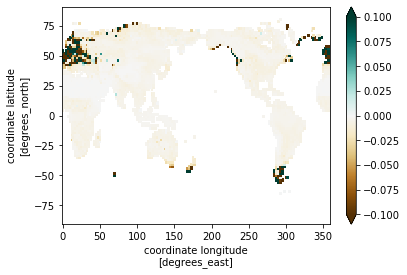

In [91]:
delta_EF_mean_of_means.plot(vmin=-0.1, vmax=0.1, cmap=plt.cm.BrBG)

In [92]:
print(1)

1


In [94]:
prefix=1/(4*emissivity_ref*CONSTANT_sigma*(Ts**3))
delta_albedo=albedo-albedo_ref
dTs_from_albedo=-prefix*met_ref.SWin*delta_albedo

In [104]:
dTs_from_albedo_mean=dTs_from_albedo.mean(dim='time').load()

In [98]:
not_albedo=dTs_actual-dTs_from_albedo.mean(dim='time')#.plot()

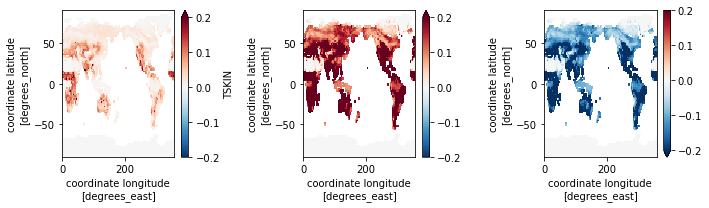

In [107]:
vmin=-0.3
vmax=0.3
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
dTs_actual.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.subplot(1,3,2)
dTs_from_albedo_mean.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.subplot(1,3,3)
not_albedo.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.tight_layout()